## Тестовое задание Бургег кинг

Описание задачи  
**Дано:** дамб базы с данными за 2017-2018 года  
**Задача:** Проведите когортный анализ и подготовьте несколько выводов  

**Инфраструктура:** не предоставлена. Ссылка на сайт с бд sqlite3   
**Оформление:** файл Word с описанием и ссылкой  
**Тип данных:** два типа: csv или bd  
**Срок выполнения:** 8 часов  
**Фидбек:** не предоставлен

Описание полей:
- day_id - дата совершения заказа
- check_time_dtm - дата и время совершения заказа
- check_qnty_id - идентификатор чека
- user_id - идентификатор пользователя
- sales - выручка с чека
- sales_wo_vat - выручка с чека без НДС
- cp_sum - себестоимость чека
- single_show_name - канал совершения заказа

In [133]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Знакомство с данными
Быстрый исследовательский анализ данных 

In [134]:
conn = sqlite3.connect('sales.db')
cursor = conn.cursor()
query = "SELECT * FROM sales limit 5"
data = pd.read_sql(query, conn)
data

,day_id,check_time_dtm,check_qnty_id,single_show_name,user_id,sales,sales_wo_vat,cp_sum
0,2017-05-09,2017-05-09 21:22:37,123393511120905255,Приложение,28355,412,374,198
1,2017-05-09,2017-05-09 20:57:06,123717511168611315,Приложение,29091,497,442,197
2,2017-05-09,2017-05-09 16:01:02,129310511160181265,Приложение,16719,150,133,73
3,2017-05-09,2017-05-09 17:12:13,123833511133042365,Приложение,25280,541,483,219
4,2017-05-09,2017-05-09 17:16:20,123833511133043255,Приложение,25280,210,185,94


Судя по структуру это датасет с покупками клиентов.  
Судя по наличиню user_id клиенты идентифицированы и авторизованы перед покупкой.

**Пропуски**  
Проверим датасет на наличие пропусков.

In [135]:
query = "SELECT count(day_id), count(check_time_dtm), count(check_qnty_id), count(single_show_name), count(user_id), count(sales), count(sales_wo_vat), count(cp_sum) FROM sales"
data = pd.read_sql(query, conn)
data.T

,0
count(day_id),108962
count(check_time_dtm),108962
count(check_qnty_id),108962
count(single_show_name),108962
count(user_id),108962
count(sales),108962
count(sales_wo_vat),108962
count(cp_sum),108962


Датасет не содержит пропусков. Объем датасета почти 109к строк.

**Дубликаты**  

Предположим, что check_qnty_id это уникальный ключ. Проверим по нему наличие дубликатов.

In [136]:
query = "SELECT count(*) as cnt, count(distinct check_qnty_id) as checks, count(distinct user_id) as users FROM sales"
data = pd.read_sql(query, conn)
data

,cnt,checks,users
0,108962,108332,4825


Количество строк больше, чем количество уникальных чеков. Изучим подробно несколько кейсов.

In [137]:
query = "SELECT   check_qnty_id, count(1)  FROM sales group by check_qnty_id having count(1)>1"
data = pd.read_sql(query, conn)
data.sample(15)

,check_qnty_id,count(1)
42,11755351519469895,2
506,14022754263766675,2
105,12301051494802055,2
241,12342851907137675,2
162,12342752131905475,2
422,13428051210906075,2
611,14236254384007575,2
412,13370850682613775,2
265,12342852274781185,2
291,123428531867930105,2


In [138]:
query = "SELECT *  FROM sales where check_qnty_id = 11878653277142755 "
data = pd.read_sql(query, conn)
data 

,day_id,check_time_dtm,check_qnty_id,single_show_name,user_id,sales,sales_wo_vat,cp_sum
0,2018-04-04,2018-04-04 17:41:42,11878653277142755,Приложение,141,71,59,18
1,2018-04-04,2018-04-04 17:41:42,11878653277142755,Приложение,141,71,59,18


In [139]:
query = "SELECT *  FROM sales where check_qnty_id = 127199541326776125 "
data = pd.read_sql(query, conn)
data 

,day_id,check_time_dtm,check_qnty_id,single_show_name,user_id,sales,sales_wo_vat,cp_sum
0,2018-08-12,2018-08-12 11:20:34,127199541326776125,Приложение,141,2,1,77
1,2018-08-12,2018-08-12 11:20:34,127199541326776125,Приложение,141,2,1,77


In [140]:
query = "SELECT *  FROM sales where check_qnty_id = 123428504352343125	 "
data = pd.read_sql(query, conn)
data 

,day_id,check_time_dtm,check_qnty_id,single_show_name,user_id,sales,sales_wo_vat,cp_sum
0,2017-01-25,2017-01-25 12:45:05,123428504352343125,Приложение,141,2,1,54
1,2017-01-25,2017-01-25 12:45:05,123428504352343125,Приложение,141,2,1,54


1. Выявлены полные дубликаты.
2. Все три кейса обьединяет один юзер с айди 141.
3. Выявлены кейсы, где себеистомость чека выше, чем сумма чека. Проверим сколько подобных кейсов.

In [141]:
query = "SELECT count(1) FROM sales where cp_sum > sales	 "
data = pd.read_sql(query, conn)
data 

,count(1)
0,8024


Теперь проверим историю юзера 141.

In [142]:
query = "SELECT * FROM sales where user_id=141 order by day_id, check_time_dtm"
data = pd.read_sql(query, conn)
data.head(30)

,day_id,check_time_dtm,check_qnty_id,single_show_name,user_id,sales,sales_wo_vat,cp_sum
0,2017-01-04,2017-01-04 11:18:19,13427750294829755,Приложение,141,75,68,14
1,2017-01-04,2017-01-04 11:18:19,13427750294829755,Приложение,141,75,68,14
2,2017-01-10,2017-01-10 12:50:04,12469950335567375,Приложение,141,1,1,22
3,2017-01-10,2017-01-10 12:50:04,12469950335567375,Приложение,141,1,1,22
4,2017-01-11,2017-01-11 14:25:24,11529450342302375,Приложение,141,1,1,22
5,2017-01-11,2017-01-11 14:25:24,11529450342302375,Приложение,141,1,1,22
6,2017-01-11,2017-01-11 14:41:28,11529450342302475,Приложение,141,1,1,22
7,2017-01-11,2017-01-11 14:41:28,11529450342302475,Приложение,141,1,1,22
8,2017-01-12,2017-01-12 11:25:05,13428250344793075,Приложение,141,1,1,22
9,2017-01-12,2017-01-12 11:25:05,13428250344793075,Приложение,141,1,1,22


In [143]:
data.tail(30)

,day_id,check_time_dtm,check_qnty_id,single_show_name,user_id,sales,sales_wo_vat,cp_sum
1222,2018-12-20,2018-12-20 11:47:22,14236254982601675,Приложение,141,1,1,22
1223,2018-12-20,2018-12-20 11:47:22,14236254982601675,Приложение,141,1,1,22
1224,2018-12-21,2018-12-21 15:59:52,130974549893734105,Приложение,141,151,137,61
1225,2018-12-21,2018-12-21 15:59:52,130974549893734105,Приложение,141,151,137,61
1226,2018-12-22,2018-12-22 12:41:17,142362549957526125,Приложение,141,2,1,79
1227,2018-12-22,2018-12-22 12:41:17,142362549957526125,Приложение,141,2,1,79
1228,2018-12-22,2018-12-22 15:36:51,142362549957589115,Приложение,141,2,1,28
1229,2018-12-22,2018-12-22 15:36:51,142362549957589115,Приложение,141,2,1,28
1230,2018-12-23,2018-12-23 13:57:06,12070255002711075,Приложение,141,1,1,21
1231,2018-12-23,2018-12-23 13:57:06,12070255002711075,Приложение,141,1,1,21


Да, это юзер с хронической проблемой дубликатов. Проверим сколько получится строк если сгруппировать дубли.

In [144]:
query = "SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum FROM sales where user_id=141 group by 1,2,3,4,5,6,7,8 order by day_id, check_time_dtm"
data = pd.read_sql(query, conn)
data.shape

(628, 8)

Действительно, один юзер нагенирил 600 дублей. Теперь проверим насколько эти дубли могут повлиять на дальнейший анализ.  
Для этого вывыедем топ юзеров по сумме трат.

In [145]:
query = "SELECT user_id,	sum(sales),	count(1), avg(sales) FROM sales  group by user_id order by sum(sales) desc"
data = pd.read_sql(query, conn)
data.head(30)

,user_id,sum(sales),count(1),avg(sales)
0,18557,144535,364,397.074176
1,21731,116598,224,520.526786
2,27606,107461,622,172.766881
3,141,105910,1252,84.592652
4,26750,105539,268,393.802239
5,26871,90179,423,213.189125
6,12279,83983,175,479.902857
7,138,79248,566,140.014134
8,5569,71770,247,290.566802
9,9744,70499,245,287.751020


Гипотеза оправдалась. С текущей ошибкой юзер 141 находится в топе по тратам, занимая 4 место. При этом количество трат и средний чек  не вписывается в цифры по остальным юзерам.
Пересчитаем этот топ без учета дублей.

In [146]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT user_id,	sum(sales),	count(1), avg(sales) FROM base group by user_id order by sum(sales) desc'''
data = pd.read_sql(query, conn)
data.head(30)

,user_id,sum(sales),count(1),avg(sales)
0,18557,144535,364,397.074176
1,21731,116598,224,520.526786
2,27606,107461,622,172.766881
3,26750,105539,268,393.802239
4,26871,90179,423,213.189125
5,12279,83983,175,479.902857
6,138,79248,566,140.014134
7,5569,71770,247,290.566802
8,9744,70499,245,287.751020
9,11851,65635,181,362.624309


Отсутствие дублей выбило юзера 141 на 28 место топа юзеров.  
Дубли отфильтрованы с помощью группировки.  
Теперь перейдем к кейсам с чеком, который меньше себестоимости.

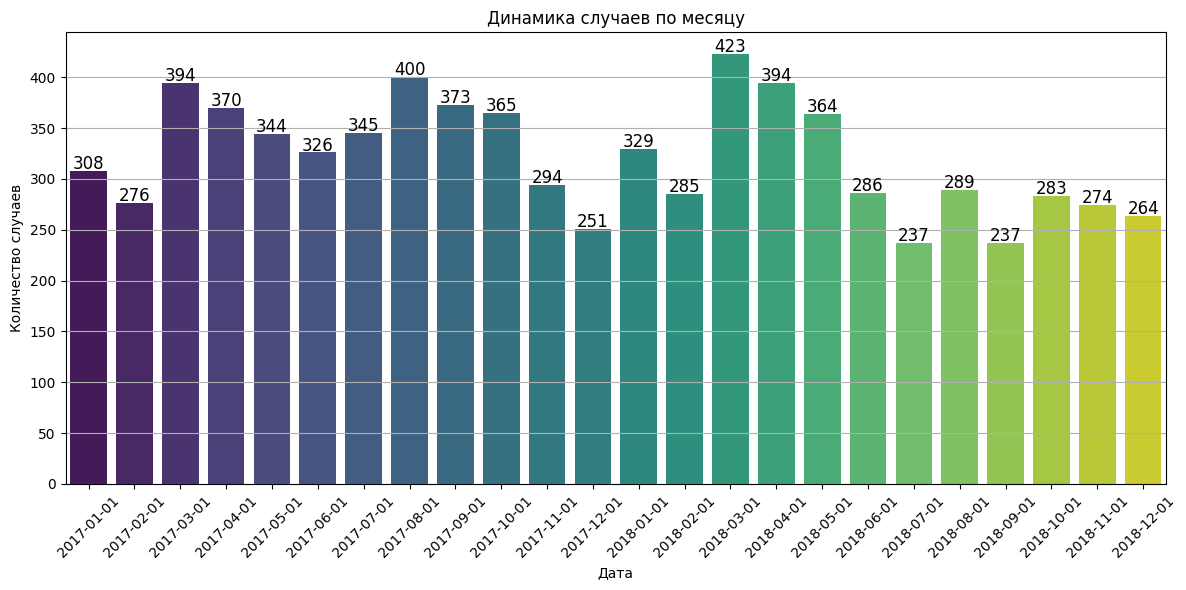

In [148]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT strftime('%Y-%m', day_id) AS truncated_date, count(1) as cases FROM base where cp_sum > sales	group by strftime('%Y-%m', day_id) '''
data = pd.read_sql(query, conn)

# Группировка по дате и суммирование случаев
data['truncated_date'] = pd.to_datetime(data['truncated_date'])

# Визуализация
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=data, x='truncated_date', y='cases', palette='viridis')

# Добавляем значения над столбцами
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     size=12, color='black', 
                     xytext=(0, 5),  # смещение текста
                     textcoords='offset points')

plt.title('Динамика случаев по месяцу')
plt.xlabel('Дата')
plt.ylabel('Количество случаев')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Мы видим, что такие кейсы присутсвуют в каждом месяце изучаемого периода.  
Теперь изучим долю подобных кейсов от общего количества чеков.

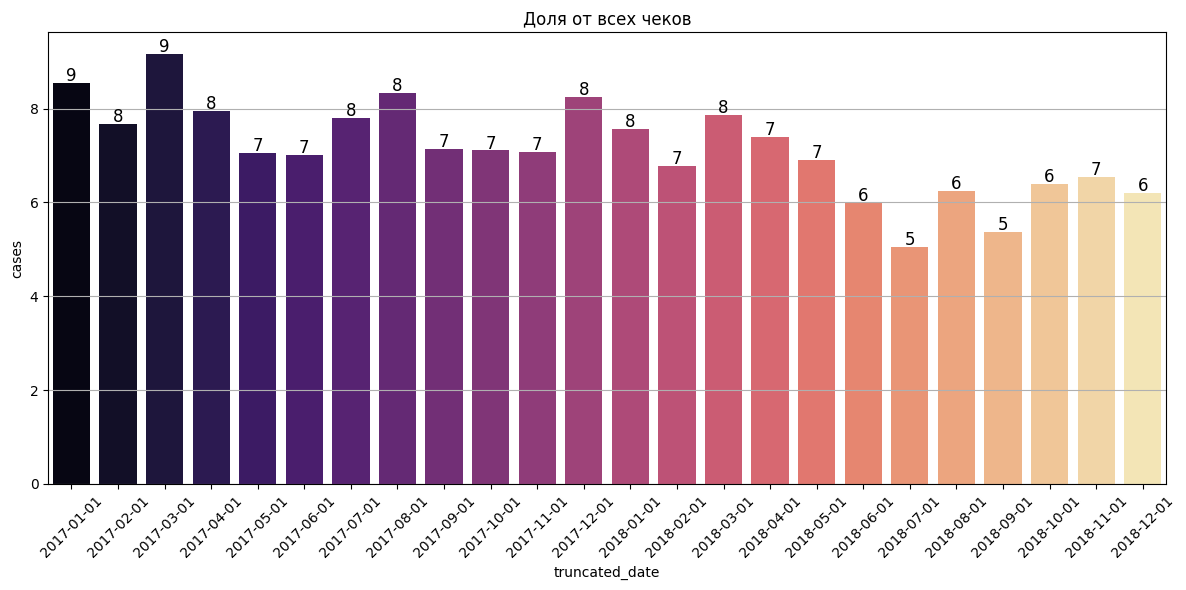

In [149]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT 
strftime('%Y-%m', day_id) AS truncated_date, 
sum(case when cp_sum > sales then 1 else 0 end)*1.0/count(1)*1.0*100 as cases 
FROM base	
group by strftime('%Y-%m', day_id) '''
data = pd.read_sql(query, conn)
data
data['truncated_date'] = pd.to_datetime(data['truncated_date'])

# Визуализация
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=data, x='truncated_date', y='cases', palette='magma')

# Добавляем значения над столбцами
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     size=12, color='black', 
                     xytext=(0, 5),  # смещение текста
                     textcoords='offset points')

plt.title('Доля от всех чеков')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Итого: от 5% до 9% в зависимости от месяца. Возможно это какая-то промоакция для привлечения новых клиентов, либо промокоды.  
Посмотрим средний чек

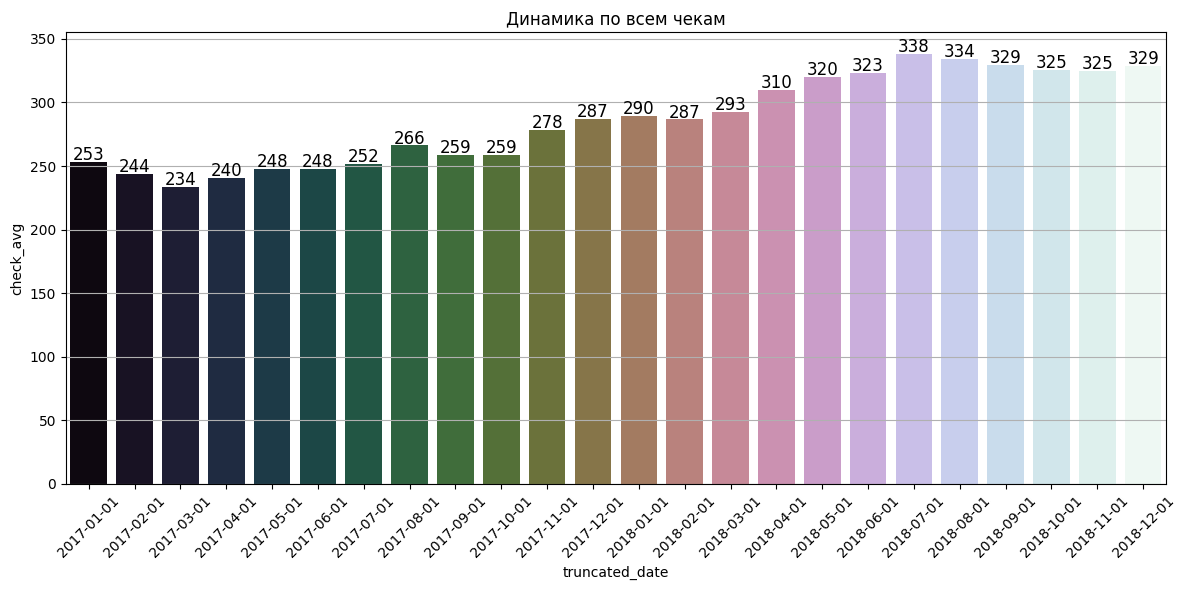

In [150]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8) 
SELECT 
strftime('%Y-%m', day_id) AS truncated_date, 
AVG(SALES) as check_avg 
FROM base
group by strftime('%Y-%m', day_id) '''
data = pd.read_sql(query, conn)
data['truncated_date'] = pd.to_datetime(data['truncated_date'])

# Визуализация
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=data, x='truncated_date', y='check_avg', palette='cubehelix')

# Добавляем значения над столбцами
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     size=12, color='black', 
                     xytext=(0, 5),  # смещение текста
                     textcoords='offset points')

plt.title('Динамика по всем чекам')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Средний чек растёт. Посмотрим какие есть каналы продаж

In [31]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8) 
SELECT 
single_show_name, 
count(1) as cnt
FROM base
group by single_show_name '''
data = pd.read_sql(query, conn)
data

,single_show_name,cnt
0,Киоск,21183
1,Приложение,87155


Большинство заказов осуществляется в приложении.   
При этом есть канал "Киоск".  
Уточнил в ближайшем БК, под Киоском подразумеватся стойки самостоятельного заказа.  
Посмотрим динамику отдельно по каждому из каналов продаж.

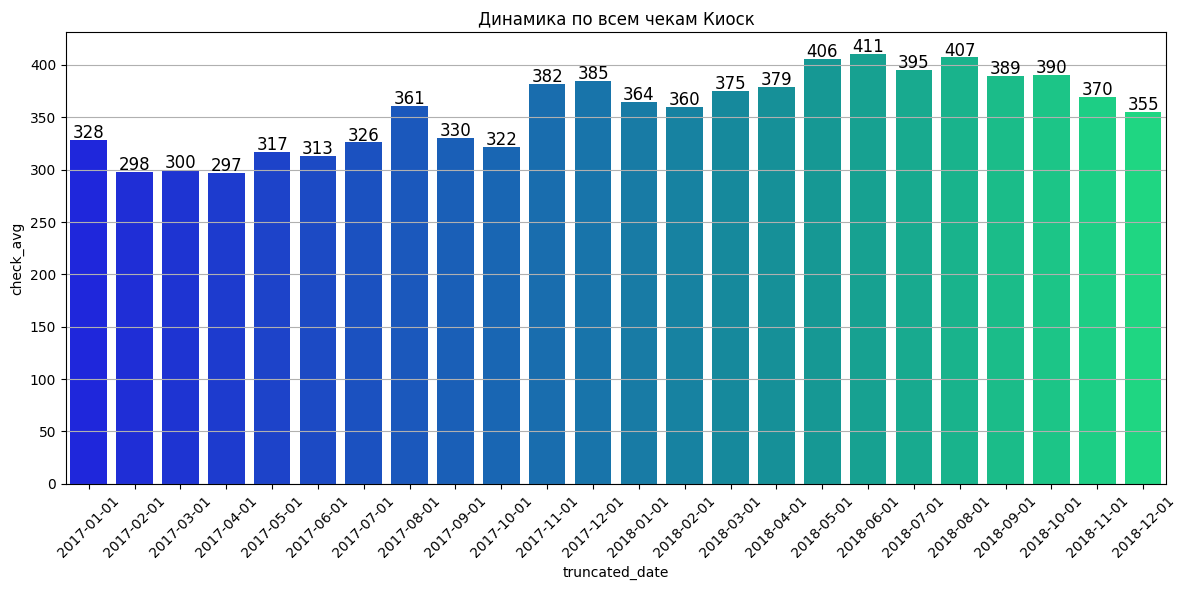

In [151]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8) 
SELECT 
strftime('%Y-%m', day_id) AS truncated_date, 
AVG(SALES) as check_avg 
FROM base
where single_show_name = 'Киоск'
group by strftime('%Y-%m', day_id) '''
data = pd.read_sql(query, conn)
data['truncated_date'] = pd.to_datetime(data['truncated_date'])

# Визуализация
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=data, x='truncated_date', y='check_avg', palette='winter')

# Добавляем значения над столбцами
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     size=12, color='black', 
                     xytext=(0, 5),  # смещение текста
                     textcoords='offset points')

plt.title('Динамика по всем чекам Киоск')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

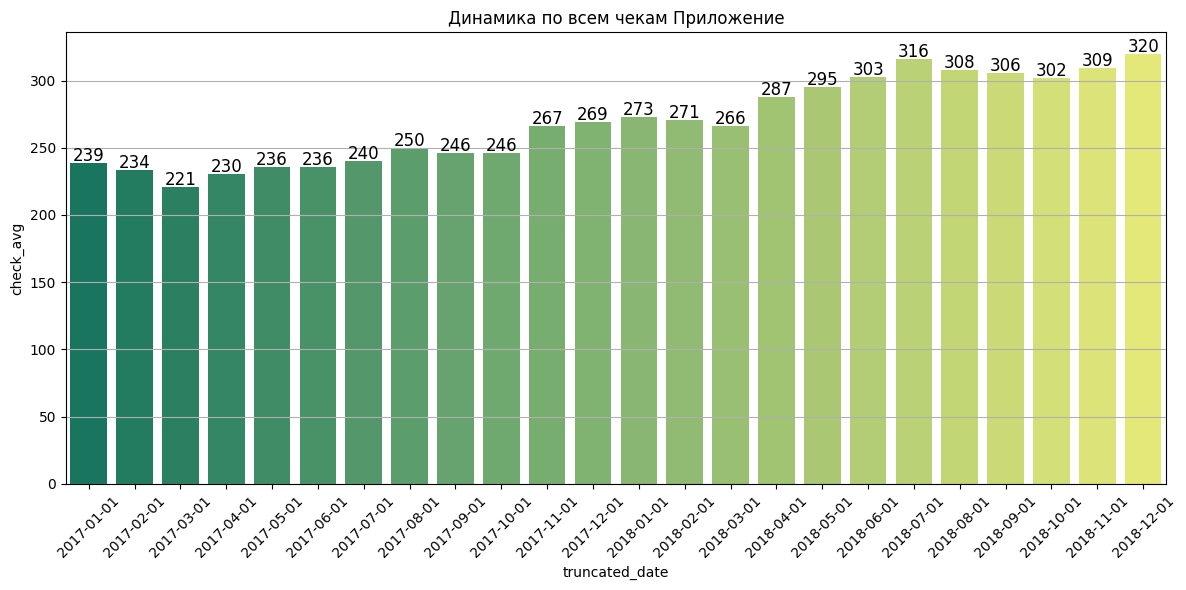

In [152]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8) 
SELECT 
strftime('%Y-%m', day_id) AS truncated_date, 
AVG(SALES) as check_avg 
FROM base
where single_show_name = 'Приложение'
group by strftime('%Y-%m', day_id) '''
data = pd.read_sql(query, conn)
data['truncated_date'] = pd.to_datetime(data['truncated_date'])

# Визуализация
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=data, x='truncated_date', y='check_avg', palette='summer')

# Добавляем значения над столбцами
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     size=12, color='black', 
                     xytext=(0, 5),  # смещение текста
                     textcoords='offset points')

plt.title('Динамика по всем чекам Приложение')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Итого средний чек в Приложении растет равномерно, средний чек в Киоске не демонстрирует ровную динамику роста. Пик приходится на май, апрель, июль.  
К декабрю 2018 наблюдается отрицательная динамика.  

Выведем отдельно разницу между средним чеком в Киоске и приложении.

In [40]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8) 
SELECT 
strftime('%Y-%m', day_id) AS truncated_date, 
avg(case when single_show_name ='Приложение' then SALES end) - avg(case when single_show_name ='Киоск' then SALES end) as diff
FROM base
group by strftime('%Y-%m', day_id) '''
data = pd.read_sql(query, conn)
data

,truncated_date,diff
0,2017-01,-89.882830
1,2017-02,-64.112343
2,2017-03,-79.262076
3,2017-04,-66.418323
4,2017-05,-81.104191
5,2017-06,-77.280536
6,2017-07,-85.909299
7,2017-08,-110.895398
8,2017-09,-84.036216
9,2017-10,-75.525258


In [41]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8) 
SELECT  
avg(case when single_show_name ='Киоск' then SALES end) as kiosk,
avg(case when single_show_name ='Приложение' then SALES end) as app,
avg(case when single_show_name ='Приложение' then SALES end) - avg(case when single_show_name ='Киоск' then SALES end) as diff
FROM base '''
data = pd.read_sql(query, conn)
data

,kiosk,app,diff
0,363.236038,268.240491,-94.995547


Вывод: средний чек в Киоске всегда выше, чем в приложении.   
Средняя разница между чеками приложения и киоска составляет 95 руб. в рамках изучаемого периода времени.  
Но средний чек плохо отражает фактическую прибыль.  У нас есть сумма чека после вычета налогов и себестоимость чека.  
Значит мы можем определить прибыль с каждого чека.

In [153]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT
sales_wo_vat-cp_sum as profit,
b.*
FROM base b
 '''
data = pd.read_sql(query, conn)
data.sample(5)

,profit,day_id,check_time_dtm,check_qnty_id,single_show_name,user_id,sales,sales_wo_vat,cp_sum
12807,70,2017-04-09,2017-04-09 16:01:09,119072509201579155,Приложение,4175,127,113,43
25152,63,2017-06-27,2017-06-27 12:04:12,131934514338189115,Приложение,10056,105,93,30
16870,53,2017-05-05,2017-05-05 21:04:30,121176510893423105,Приложение,5778,131,112,59
50936,250,2017-12-10,2017-12-10 19:05:30,139840525217386115,Приложение,14400,577,481,231
41948,75,2017-10-11,2017-10-11 17:18:02,120978521293801115,Приложение,18538,150,136,61


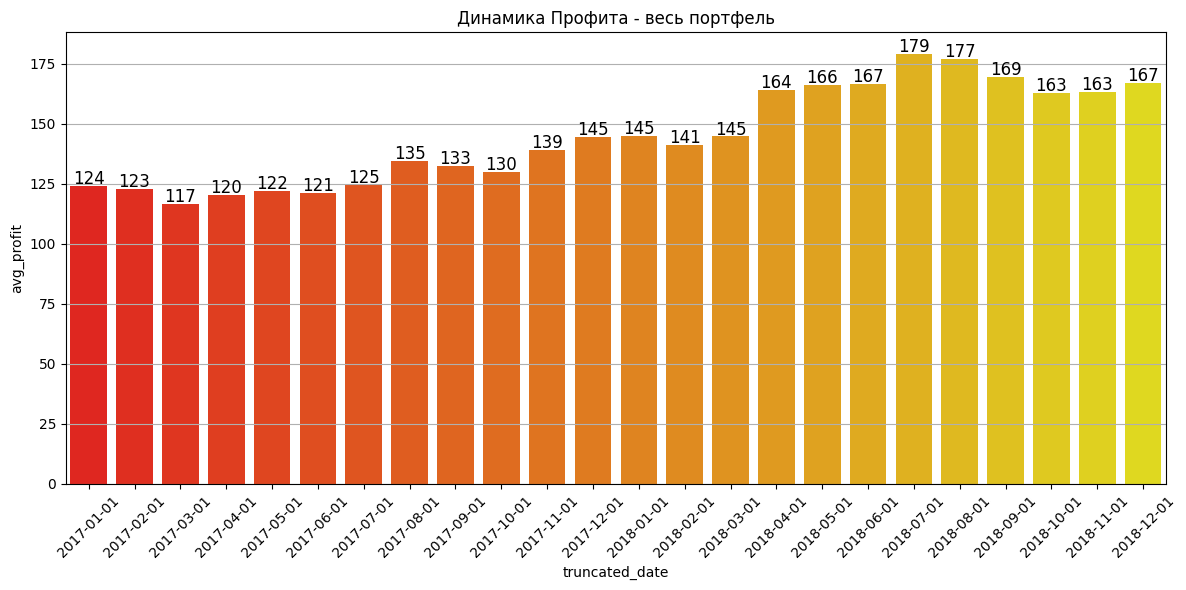

In [154]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT
strftime('%Y-%m', day_id) AS truncated_date, 
avg(sales_wo_vat-cp_sum) as avg_profit
FROM base b group by truncated_date'''
data = pd.read_sql(query, conn)
data['truncated_date'] = pd.to_datetime(data['truncated_date'])

# Визуализация
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=data, x='truncated_date', y='avg_profit', palette='autumn')

# Добавляем значения над столбцами
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     size=12, color='black', 
                     xytext=(0, 5),  # смещение текста
                     textcoords='offset points')

plt.title('Динамика Профита - весь портфель')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

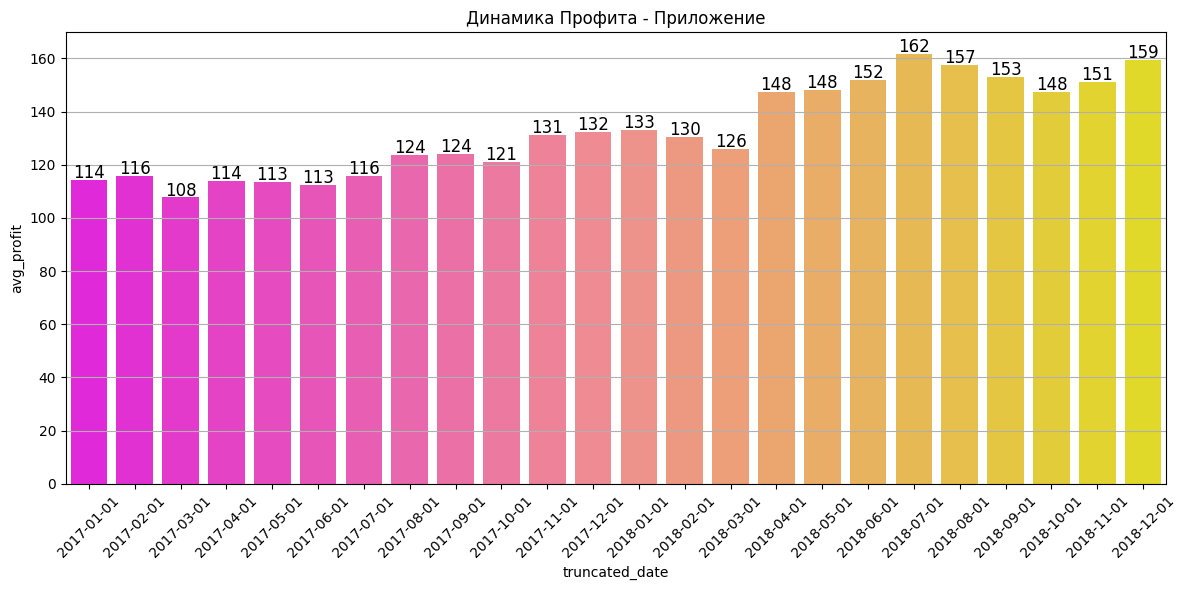

In [155]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT
strftime('%Y-%m', day_id) AS truncated_date, 
avg(sales_wo_vat-cp_sum) as avg_profit
FROM base b  where single_show_name = 'Приложение' group by truncated_date'''
data = pd.read_sql(query, conn)
data['truncated_date'] = pd.to_datetime(data['truncated_date'])

# Визуализация
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=data, x='truncated_date', y='avg_profit', palette='spring')

# Добавляем значения над столбцами
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     size=12, color='black', 
                     xytext=(0, 5),  # смещение текста
                     textcoords='offset points')

plt.title('Динамика Профита - Приложение')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

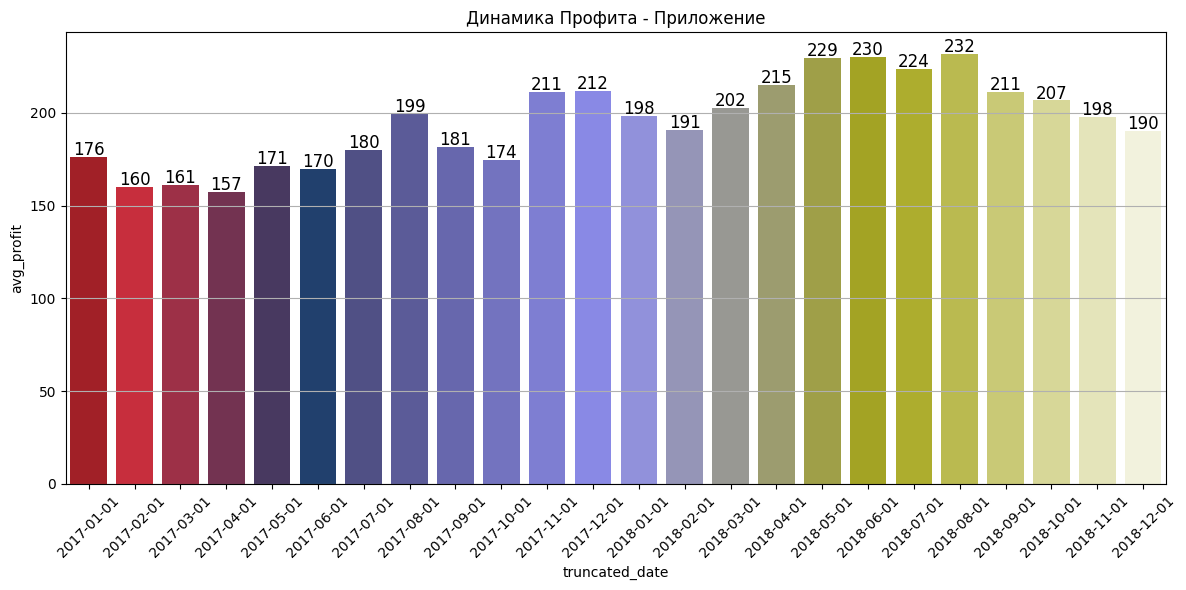

In [156]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT
strftime('%Y-%m', day_id) AS truncated_date, 
avg(sales_wo_vat-cp_sum) as avg_profit
FROM base b  where single_show_name = 'Киоск' group by truncated_date'''
data = pd.read_sql(query, conn)
data['truncated_date'] = pd.to_datetime(data['truncated_date'])

# Визуализация
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=data, x='truncated_date', y='avg_profit', palette='gist_stern')

# Добавляем значения над столбцами
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     size=12, color='black', 
                     xytext=(0, 5),  # смещение текста
                     textcoords='offset points')

plt.title('Динамика Профита - Приложение')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Аналогично предыдущей метрике мы видим ровный рост в Приложении и отсутствие односторонней динамики в Киоске. 

### Когортный анализ

В рамках задачи рассмотрим когортный подход по месяцу первой покупки.  
Для этого дополним наш датафрейм когортами с помощью оконной функции. Добавим метрику профита.  
Отранжируем каждую покупку по окну клиент, чтобы в дальнейшем отфильтровать самую первую покупку, как признак когорты.

In [157]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk
FROM base b
 '''
data = pd.read_sql(query, conn)
data.head(22)

,day_id,check_time_dtm,check_qnty_id,single_show_name,user_id,sales,sales_wo_vat,cp_sum,profit,first_date,rnk
0,2017-01-18,2017-01-18 17:30:32,12128750386524375,Приложение,17,1,1,11,-10,2017-01-18,1
1,2017-01-18,2017-01-18 17:41:33,12128750386524575,Приложение,17,1,1,11,-10,2017-01-18,2
2,2017-01-18,2017-01-18 17:53:32,12128750386524875,Приложение,17,1,1,11,-10,2017-01-18,3
3,2017-01-19,2017-01-19 12:39:15,12123150393698975,Приложение,25,1,1,12,-11,2017-01-19,1
4,2017-02-04,2017-02-04 12:54:18,12698150497020175,Приложение,25,1,1,11,-10,2017-01-19,2
5,2017-02-09,2017-02-09 14:01:56,13020550529034285,Приложение,25,1,1,11,-10,2017-01-19,3
6,2017-02-09,2017-02-09 14:06:39,13020550529034485,Приложение,25,1,1,11,-10,2017-01-19,4
7,2017-02-17,2017-02-17 19:52:08,12546750582875685,Приложение,25,1,1,59,-58,2017-01-19,5
8,2017-02-17,2017-02-17 20:09:42,12546750582876955,Приложение,25,4,4,0,4,2017-01-19,6
9,2017-03-18,2017-03-18 18:37:00,122818507756094125,Приложение,25,249,226,43,183,2017-01-19,7


Любопытно, что минусовые чеки похожи между собой суммой в 1 руб. Проверим сколько таких кейсов.

In [158]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT 
count(1)
FROM base b  
where sales = 1
 '''
data = pd.read_sql(query, conn)
data

,count(1)
0,4553


In [159]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT 
count(*)
FROM base b 
where  cp_sum > sales_wo_vat
 '''
data = pd.read_sql(query, conn)
data

,count(*)
0,8113


Итого получается из 8 тысяч чеков с отрицательной прибылью, 4,5 тысячи это чеки на 1 руб.  
Очень похоже на какую-то промоакцию.  
В данном случае требуется коммуникация с представителем бизнеса для выяснения насколько эта логика соотвествует логике продукта. Нет ли тут технических ошибок. 
В рамках задачи, предположим, что данные соотвествуют бизнес-логике и не будем исключать их из дальнейшего анализа.

Для перехода к когортному анализу, помимо предыдущих признаков, к датасету необходимо добавить порядковый признак моба(поколения жизни клиента).  
В рамках данного исследования под мобом мы понимаем период в 30 дней. Мобы рассчитываются с даты первой покупки по каждому клиенту.

In [160]:
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8)
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b
 '''
data = pd.read_sql(query, conn)
data.head(22)

,day_id,check_time_dtm,check_qnty_id,single_show_name,user_id,sales,sales_wo_vat,cp_sum,profit,first_date,rnk,mob
0,2017-01-18,2017-01-18 17:30:32,12128750386524375,Приложение,17,1,1,11,-10,2017-01-18,1,0
1,2017-01-18,2017-01-18 17:41:33,12128750386524575,Приложение,17,1,1,11,-10,2017-01-18,2,0
2,2017-01-18,2017-01-18 17:53:32,12128750386524875,Приложение,17,1,1,11,-10,2017-01-18,3,0
3,2017-01-19,2017-01-19 12:39:15,12123150393698975,Приложение,25,1,1,12,-11,2017-01-19,1,0
4,2017-02-04,2017-02-04 12:54:18,12698150497020175,Приложение,25,1,1,11,-10,2017-01-19,2,0
5,2017-02-09,2017-02-09 14:01:56,13020550529034285,Приложение,25,1,1,11,-10,2017-01-19,3,0
6,2017-02-09,2017-02-09 14:06:39,13020550529034485,Приложение,25,1,1,11,-10,2017-01-19,4,0
7,2017-02-17,2017-02-17 19:52:08,12546750582875685,Приложение,25,1,1,59,-58,2017-01-19,5,0
8,2017-02-17,2017-02-17 20:09:42,12546750582876955,Приложение,25,4,4,0,4,2017-01-19,6,0
9,2017-03-18,2017-03-18 18:37:00,122818507756094125,Приложение,25,249,226,43,183,2017-01-19,7,1


#### Клиенты

Построим винтаж по активной клиентской базе. Наличие чеков = активность клиента в мобе.

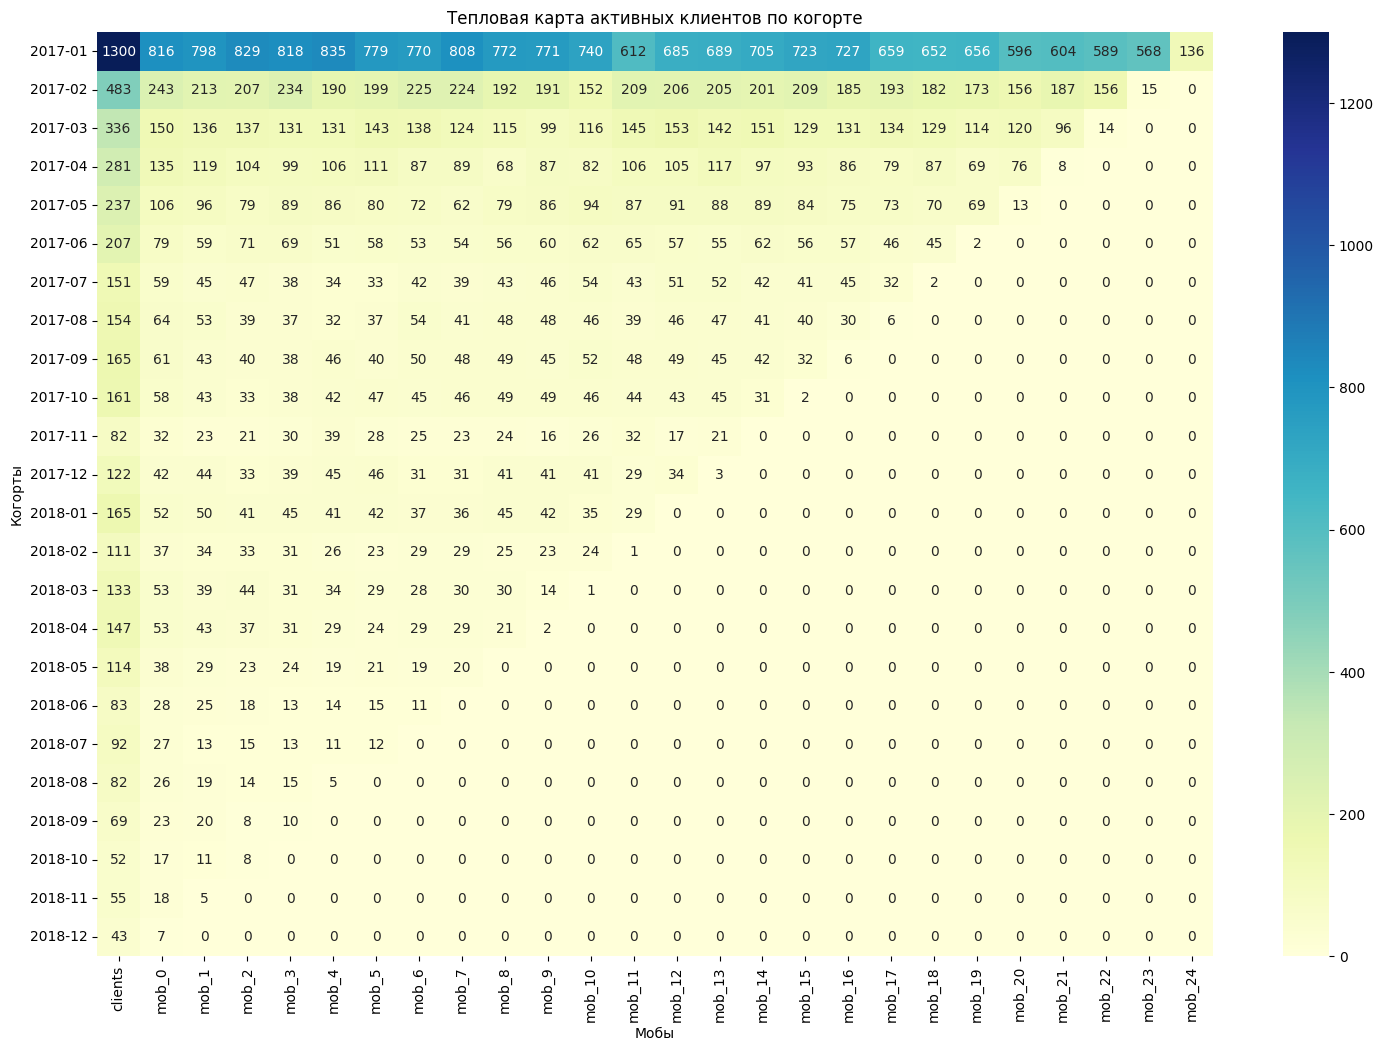

In [162]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  strftime('%Y-%m', cb.first_date) as cohort,
count(distinct case when rnk = 1 then user_id end) as clients,
count(distinct case when rnk > 1 and mob=0 then user_id end) as mob_0,
count(distinct case when mob=1 then user_id end) as mob_1,
count(distinct case when mob=2 then user_id end) as mob_2,
count(distinct case when mob=3 then user_id end) as mob_3,
count(distinct case when mob=4 then user_id end) as mob_4,
count(distinct case when mob=5 then user_id end) as mob_5,
count(distinct case when mob=6 then user_id end) as mob_6,
count(distinct case when mob=7 then user_id end) as mob_7,
count(distinct case when mob=8 then user_id end) as mob_8,
count(distinct case when mob=9 then user_id end) as mob_9,
count(distinct case when mob=10 then user_id end) as mob_10,
count(distinct case when mob=11 then user_id end) as mob_11,
count(distinct case when mob=12 then user_id end) as mob_12,
count(distinct case when mob=13 then user_id end) as mob_13,
count(distinct case when mob=14 then user_id end) as mob_14,
count(distinct case when mob=15 then user_id end) as mob_15,
count(distinct case when mob=16 then user_id end) as mob_16,
count(distinct case when mob=17 then user_id end) as mob_17,
count(distinct case when mob=18 then user_id end) as mob_18,
count(distinct case when mob=19 then user_id end) as mob_19,
count(distinct case when mob=20 then user_id end) as mob_20,
count(distinct case when mob=21 then user_id end) as mob_21,
count(distinct case when mob=22 then user_id end) as mob_22,
count(distinct case when mob=23 then user_id end) as mob_23,
count(distinct case when mob=24 then user_id end) as mob_24
from clear_base cb
group by strftime('%Y-%m', cb.first_date)
 '''
data = pd.read_sql(query, conn)
data.set_index('cohort', inplace=True)

# Построение тепловой карты
plt.figure(figsize=(18, 12))
sns.heatmap(data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Тепловая карта активных клиентов по когорте')
plt.ylabel('Когорты')
plt.xlabel('Мобы')
plt.show()

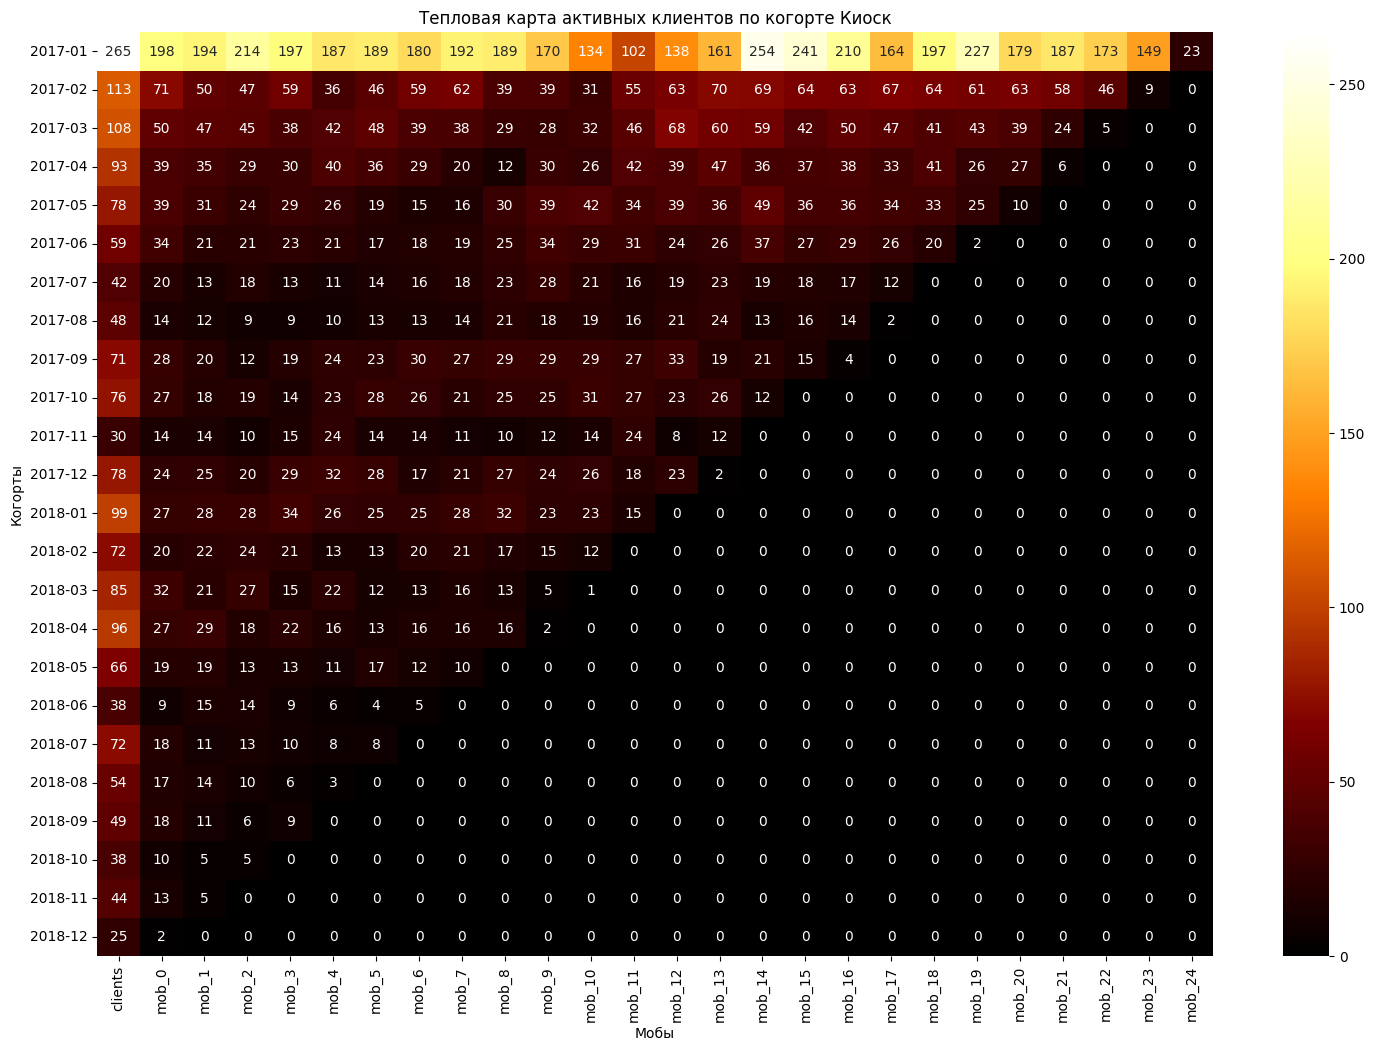

In [163]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  strftime('%Y-%m', cb.first_date) as cohort,
count(distinct case when rnk = 1 then user_id end) as clients,
count(distinct case when rnk > 1 and mob=0 then user_id end) as mob_0,
count(distinct case when mob=1 then user_id end) as mob_1,
count(distinct case when mob=2 then user_id end) as mob_2,
count(distinct case when mob=3 then user_id end) as mob_3,
count(distinct case when mob=4 then user_id end) as mob_4,
count(distinct case when mob=5 then user_id end) as mob_5,
count(distinct case when mob=6 then user_id end) as mob_6,
count(distinct case when mob=7 then user_id end) as mob_7,
count(distinct case when mob=8 then user_id end) as mob_8,
count(distinct case when mob=9 then user_id end) as mob_9,
count(distinct case when mob=10 then user_id end) as mob_10,
count(distinct case when mob=11 then user_id end) as mob_11,
count(distinct case when mob=12 then user_id end) as mob_12,
count(distinct case when mob=13 then user_id end) as mob_13,
count(distinct case when mob=14 then user_id end) as mob_14,
count(distinct case when mob=15 then user_id end) as mob_15,
count(distinct case when mob=16 then user_id end) as mob_16,
count(distinct case when mob=17 then user_id end) as mob_17,
count(distinct case when mob=18 then user_id end) as mob_18,
count(distinct case when mob=19 then user_id end) as mob_19,
count(distinct case when mob=20 then user_id end) as mob_20,
count(distinct case when mob=21 then user_id end) as mob_21,
count(distinct case when mob=22 then user_id end) as mob_22,
count(distinct case when mob=23 then user_id end) as mob_23,
count(distinct case when mob=24 then user_id end) as mob_24
from clear_base cb
where cb.single_show_name = 'Киоск'
group by strftime('%Y-%m', cb.first_date)
 '''
data = pd.read_sql(query, conn)
data.set_index('cohort', inplace=True)

# Построение тепловой карты
plt.figure(figsize=(18, 12))
sns.heatmap(data, annot=True, fmt='d', cmap='afmhot')
plt.title('Тепловая карта активных клиентов по когорте Киоск')
plt.ylabel('Когорты')
plt.xlabel('Мобы')
plt.show()

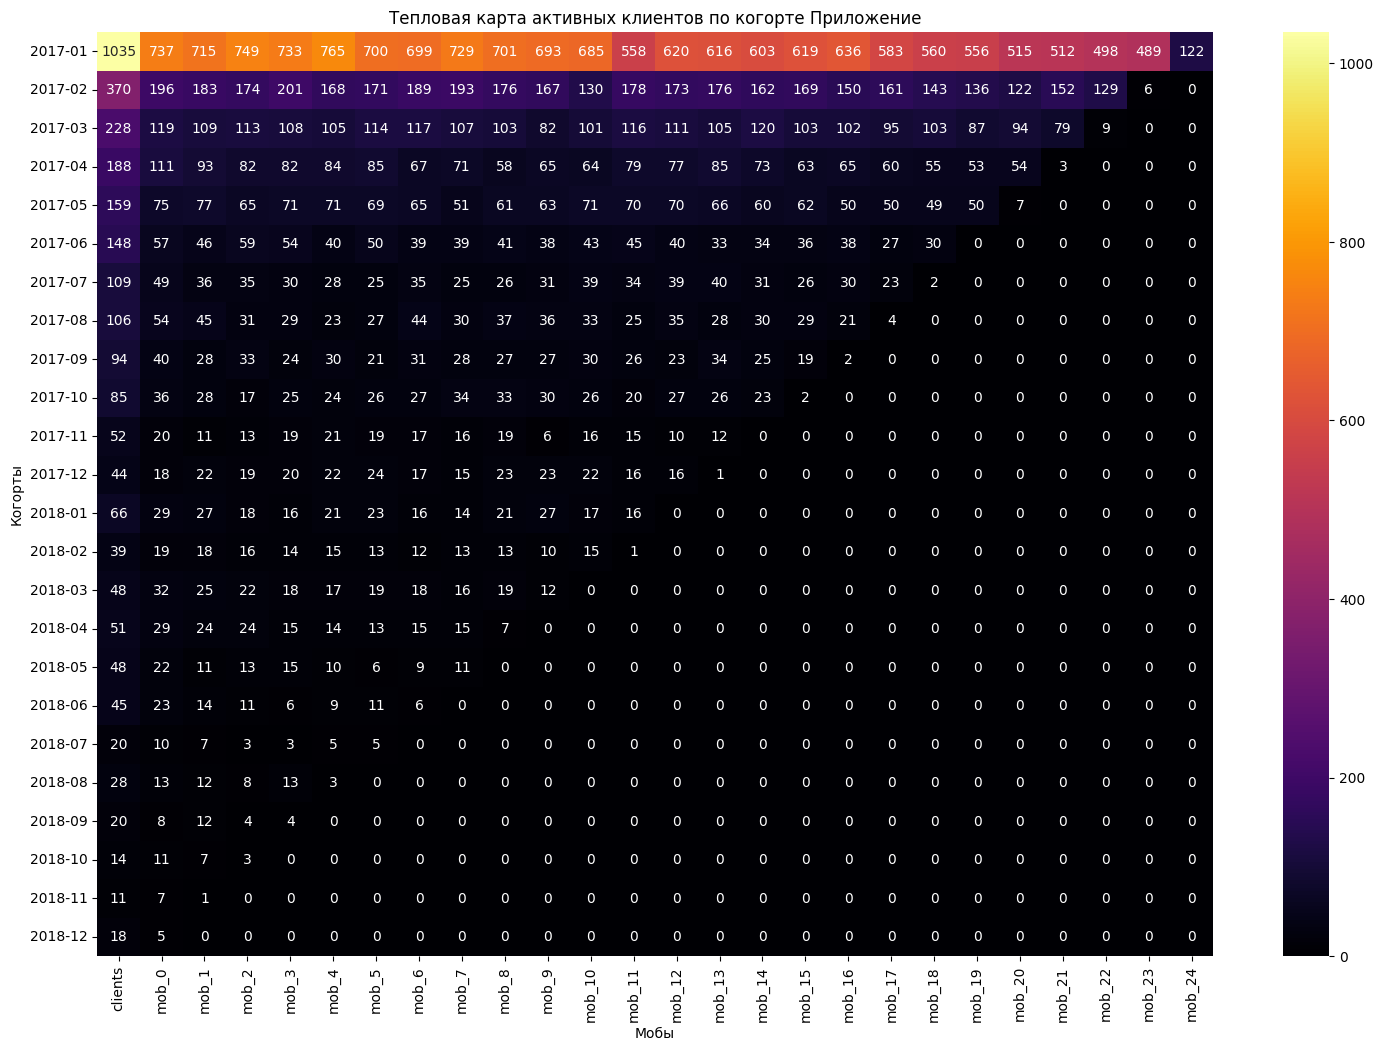

In [164]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  strftime('%Y-%m', cb.first_date) as cohort,
count(distinct case when rnk = 1 then user_id end) as clients,
count(distinct case when rnk > 1 and mob=0 then user_id end) as mob_0,
count(distinct case when mob=1 then user_id end) as mob_1,
count(distinct case when mob=2 then user_id end) as mob_2,
count(distinct case when mob=3 then user_id end) as mob_3,
count(distinct case when mob=4 then user_id end) as mob_4,
count(distinct case when mob=5 then user_id end) as mob_5,
count(distinct case when mob=6 then user_id end) as mob_6,
count(distinct case when mob=7 then user_id end) as mob_7,
count(distinct case when mob=8 then user_id end) as mob_8,
count(distinct case when mob=9 then user_id end) as mob_9,
count(distinct case when mob=10 then user_id end) as mob_10,
count(distinct case when mob=11 then user_id end) as mob_11,
count(distinct case when mob=12 then user_id end) as mob_12,
count(distinct case when mob=13 then user_id end) as mob_13,
count(distinct case when mob=14 then user_id end) as mob_14,
count(distinct case when mob=15 then user_id end) as mob_15,
count(distinct case when mob=16 then user_id end) as mob_16,
count(distinct case when mob=17 then user_id end) as mob_17,
count(distinct case when mob=18 then user_id end) as mob_18,
count(distinct case when mob=19 then user_id end) as mob_19,
count(distinct case when mob=20 then user_id end) as mob_20,
count(distinct case when mob=21 then user_id end) as mob_21,
count(distinct case when mob=22 then user_id end) as mob_22,
count(distinct case when mob=23 then user_id end) as mob_23,
count(distinct case when mob=24 then user_id end) as mob_24
from clear_base cb
where cb.single_show_name = 'Приложение'
group by strftime('%Y-%m', cb.first_date)
 '''
data = pd.read_sql(query, conn)
data.set_index('cohort', inplace=True)

# Построение тепловой карты
plt.figure(figsize=(18, 12))
sns.heatmap(data, annot=True, fmt='d', cmap='inferno')
plt.title('Тепловая карта активных клиентов по когорте Приложение')
plt.ylabel('Когорты')
plt.xlabel('Мобы')
plt.show()

В целом по абсолютным значениям и по Киоску и по Приложению наблюдается одинаковая динамика по первым когортам, которые являются самыми активными и генерят основную активность в двух каналах.  
Так же на абсолютных значениях хорошо видно, что активность минус первого моба(первый чек) по приложению демонстрируют отрицательную динамику.  
А вот по Киоску отрицательной динамики не наблюдается. Как и положительной.  АКБ плавающая в диапазоне от 40 до 90.

Построим винтаж в относительных значениях: доля активных клиентов от первоначальной численного когорты.

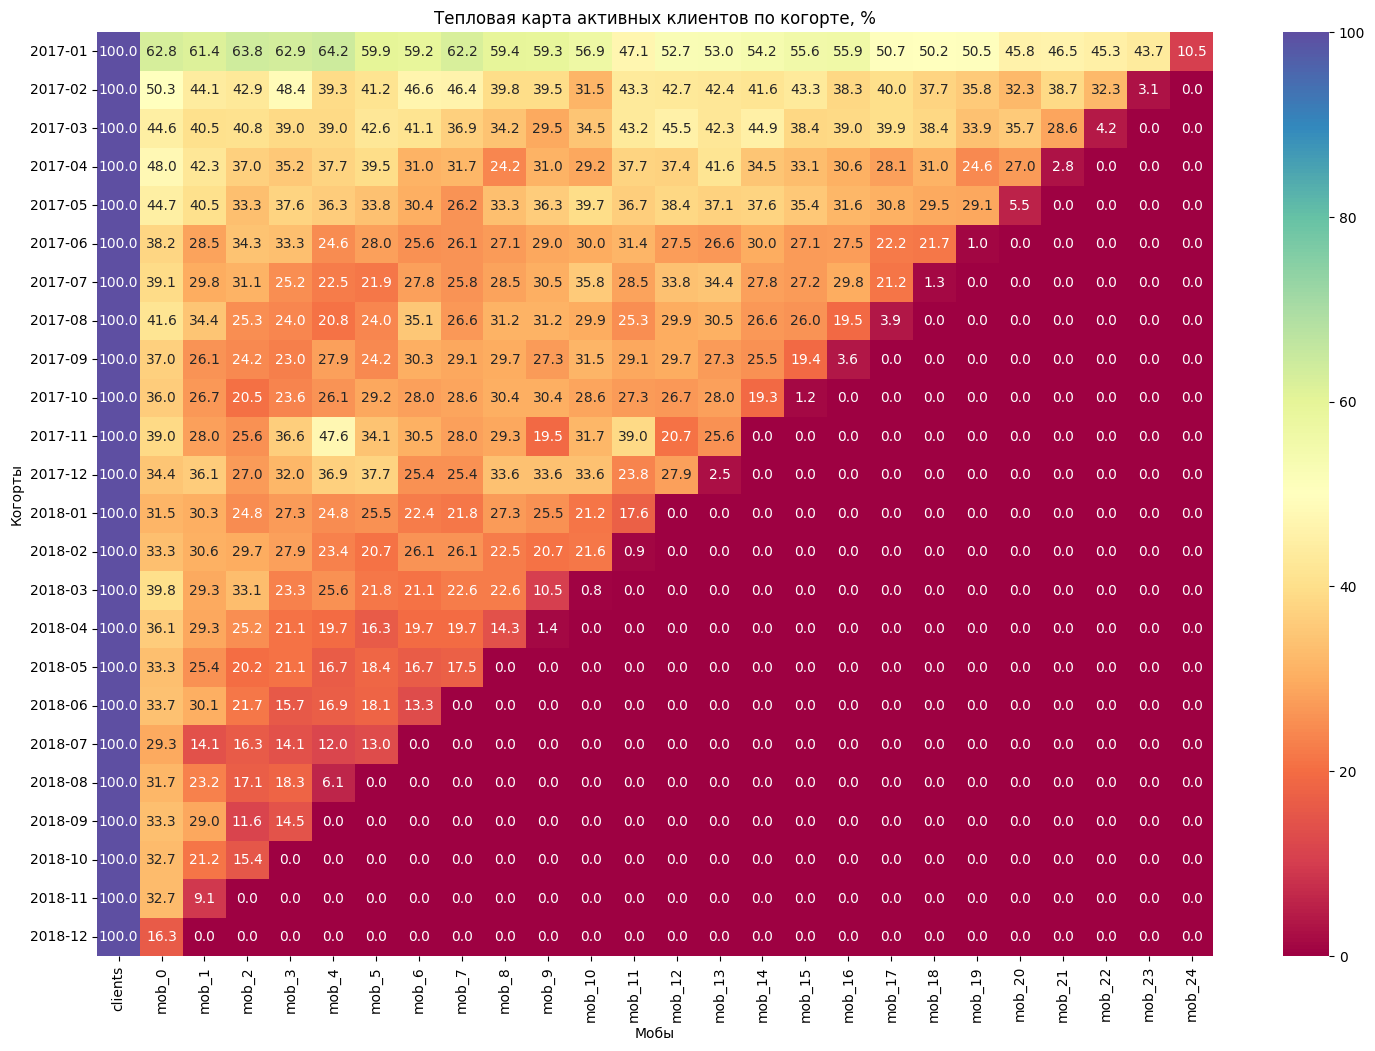

In [95]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  strftime('%Y-%m', cb.first_date) as cohort,
100 as clients,
count(distinct case when rnk > 1 and mob=0 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_0,
count(distinct case when mob=1 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_1,
count(distinct case when mob=2 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_2,
count(distinct case when mob=3 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_3,
count(distinct case when mob=4 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_4,
count(distinct case when mob=5 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_5,
count(distinct case when mob=6 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_6,
count(distinct case when mob=7 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_7,
count(distinct case when mob=8 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_8,
count(distinct case when mob=9 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_9,
count(distinct case when mob=10 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_10,
count(distinct case when mob=11 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_11,
count(distinct case when mob=12 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_12,
count(distinct case when mob=13 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_13,
count(distinct case when mob=14 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_14,
count(distinct case when mob=15 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_15,
count(distinct case when mob=16 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_16,
count(distinct case when mob=17 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_17,
count(distinct case when mob=18 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_18,
count(distinct case when mob=19 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_19,
count(distinct case when mob=20 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_20,
count(distinct case when mob=21 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_21,
count(distinct case when mob=22 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_22,
count(distinct case when mob=23 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_23,
count(distinct case when mob=24 then user_id end)*1.0/count(distinct case when rnk = 1 then user_id end)*1.0*100 as mob_24
from clear_base cb
group by strftime('%Y-%m', cb.first_date)
 '''
data = pd.read_sql(query, conn)
data.set_index('cohort', inplace=True)

# Построение тепловой карты
plt.figure(figsize=(18, 12))
sns.heatmap(data, annot=True, fmt='.1f', cmap='Spectral')
plt.title('Тепловая карта активных клиентов по когорте, %')
plt.ylabel('Когорты')
plt.xlabel('Мобы')
plt.show()

Удивительную живучесть демонстрирует самая первая когорта. Спустя почти 2 года 44% активных клиентов.  
Это значительно выше, чем другие когорты, которые увядают до 20-25% АКБ в первые 6-12 месяцев.  
По самым свежим когортам динамика еще хуже.

#### Средний чек

Классическая метрика - средний чек.  
Изучим динамику по средним чекам в рамках мобов.

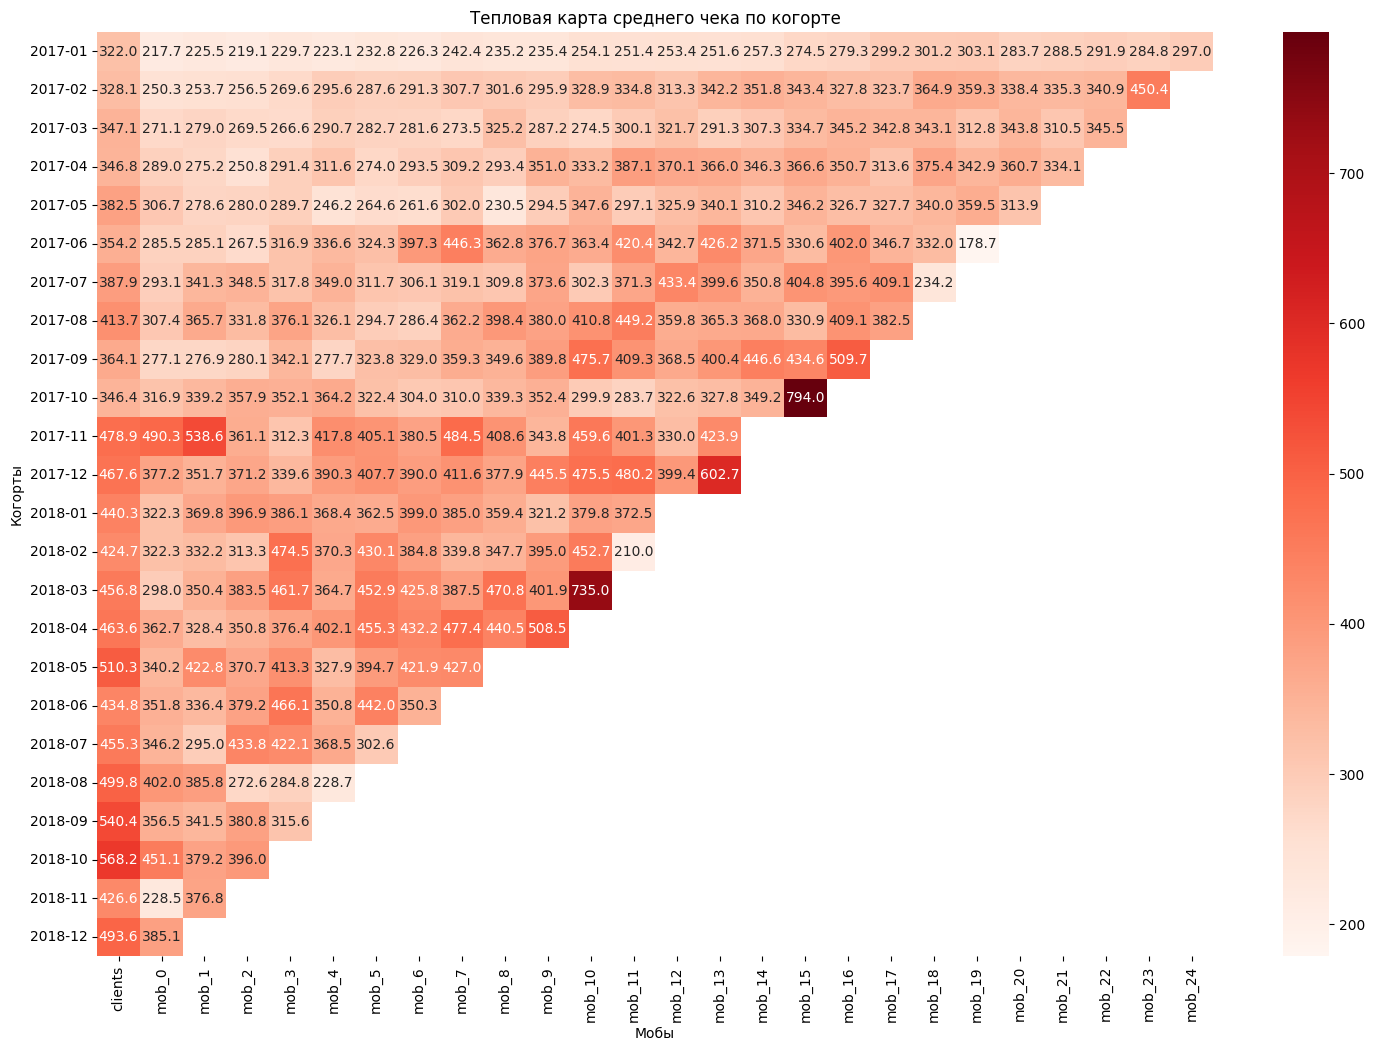

In [104]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  strftime('%Y-%m', cb.first_date) as cohort,
avg(case when rnk = 1 then sales end) as clients,
avg(case when rnk > 1 and mob=0 then sales end) as mob_0,
avg(case when mob=1 then sales end) as mob_1,
avg(case when mob=2 then sales end) as mob_2,
avg(case when mob=3 then sales end) as mob_3,
avg(case when mob=4 then sales end) as mob_4,
avg(case when mob=5 then sales end) as mob_5,
avg(case when mob=6 then sales end) as mob_6,
avg(case when mob=7 then sales end) as mob_7,
avg(case when mob=8 then sales end) as mob_8,
avg(case when mob=9 then sales end) as mob_9,
avg(case when mob=10 then sales end) as mob_10,
avg(case when mob=11 then sales end) as mob_11,
avg(case when mob=12 then sales end) as mob_12,
avg(case when mob=13 then sales end) as mob_13,
avg(case when mob=14 then sales end) as mob_14,
avg(case when mob=15 then sales end) as mob_15,
avg(case when mob=16 then sales end) as mob_16,
avg(case when mob=17 then sales end) as mob_17,
avg(case  when mob=18 then sales end) as mob_18,
avg(case when mob=19 then sales end) as mob_19,
avg(case when mob=20 then sales end) as mob_20,
avg(case when mob=21 then sales end) as mob_21,
avg(case when mob=22 then sales end) as mob_22,
avg(case when mob=23 then sales end) as mob_23,
avg(case when mob=24 then sales end) as mob_24
from clear_base cb
group by strftime('%Y-%m', cb.first_date)
 '''
data = pd.read_sql(query, conn)
data.set_index('cohort', inplace=True)

# Построение тепловой карты
plt.figure(figsize=(18, 12))
sns.heatmap(data, annot=True, fmt='.1f', cmap='Reds')
plt.title('Тепловая карта среднего чека по когорте')
plt.ylabel('Когорты')
plt.xlabel('Мобы')
plt.show()

Наблюдаем минимальный средний чек на первых когортах.  
При этом показатели среднечего первой когорты на последних мобах практически в два раза ниже, чем средний чек у новых клиентов в этом же периоде.   
Гипотеза про спец.условия, промокоды и акции для первых когорт подтверждается.

#### Покупки

Проверим предыдущий вывод с помощью метрики: частота покупок на 1 клиента.  
Это метрика позволит опеределить активность клиентов.

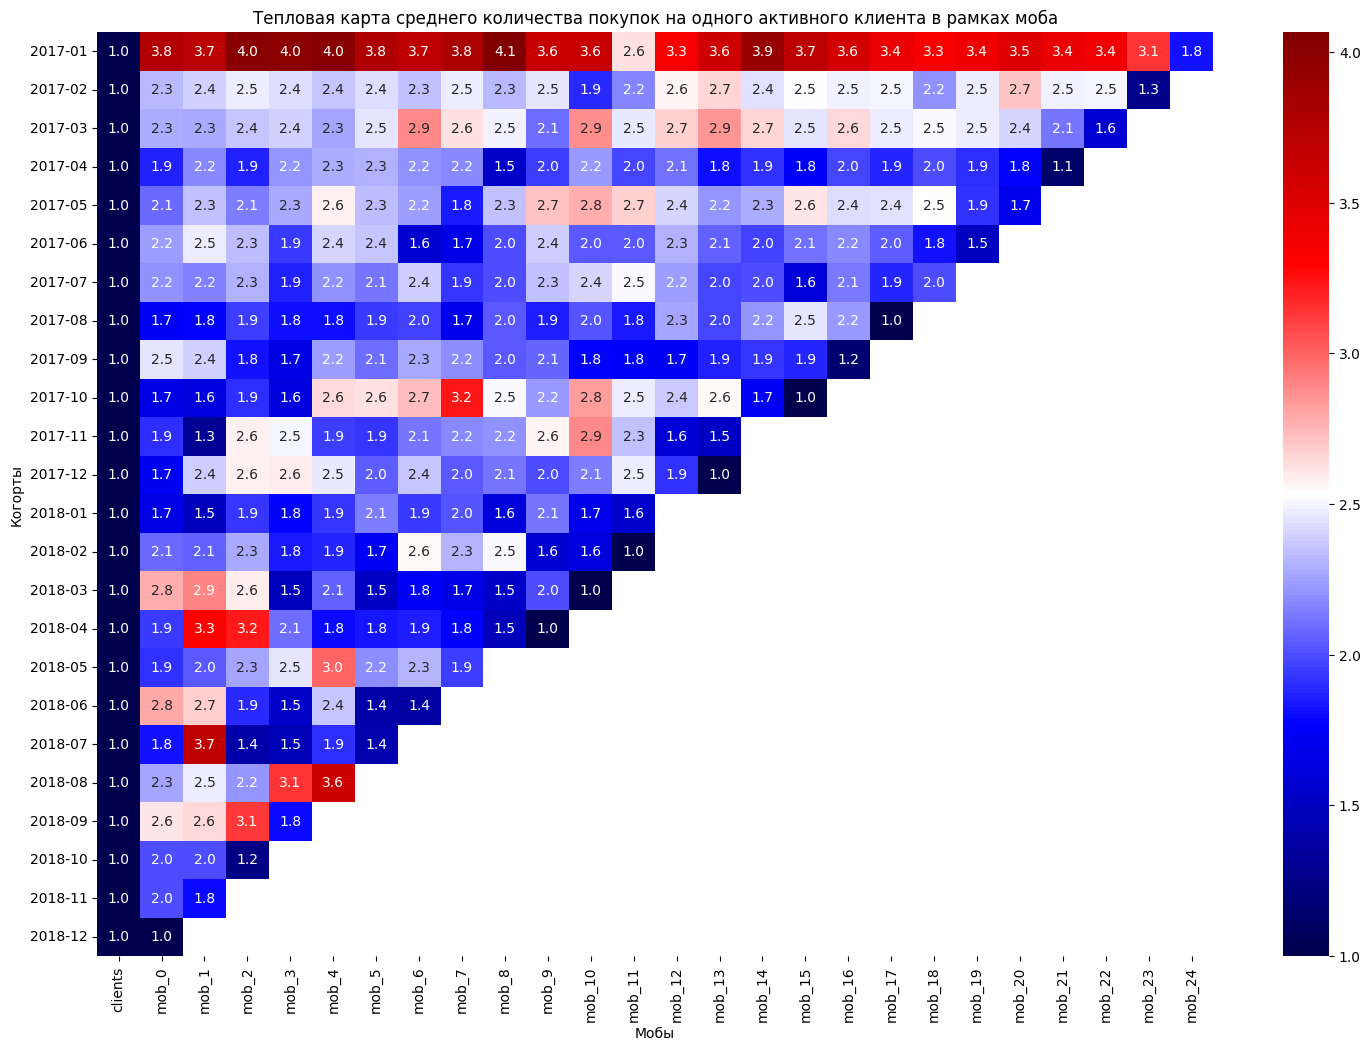

In [127]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  strftime('%Y-%m', cb.first_date) as cohort,
sum(case when rnk = 1 then 1 end)*1.0/count(distinct case when rnk = 1 then user_id  end)*1.0 as clients,
sum(case when rnk > 1 and mob=0 then 1 end)*1.0/count(distinct  case when rnk > 1 and mob=0 then user_id  end)*1.0  as mob_0,
sum(case when mob=1 then 1 end)*1.0/count(distinct case when mob=1 then user_id end)*1.0   as mob_1,
sum(case when mob=2 then 1 end)*1.0/count(distinct  case when mob=2 then user_id  end)*1.0 as mob_2,
sum(case when mob=3 then 1 end)*1.0/count(distinct  case when mob=3 then user_id  end)*1.0  as mob_3,
sum(case when mob=4 then 1   end)*1.0/count(distinct  case when mob=4 then user_id  end)*1.0   as mob_4,
sum(case when mob=5 then 1 end)*1.0/count(distinct  case when mob=5 then user_id  end)*1.0  as mob_5,
sum(case when mob=6 then 1 end)*1.0/count(distinct  case when mob=6 then user_id  end)*1.0   as mob_6,
sum(case when mob=7 then 1 end)*1.0/count(distinct  case when mob=7 then user_id  end)*1.0   as mob_7,
sum(case when mob=8 then 1 end)*1.0/count(distinct  case when mob=8 then user_id  end)*1.0   as mob_8,
sum(case when mob=9 then 1 end)*1.0/count(distinct  case when mob=9 then user_id  end)*1.0   as mob_9,
sum(case when mob=10 then 1 end)*1.0/count(distinct  case when mob=10 then user_id  end)*1.0  as mob_10,
sum(case when mob=11 then 1 end)*1.0/count(distinct  case when mob=11 then user_id  end)*1.0   as mob_11,
sum(case when mob=12 then 1 end)*1.0/count(distinct  case when mob=12 then user_id  end)*1.0  as mob_12,
sum(case when mob=13 then 1 end)*1.0/count(distinct  case when mob=13 then user_id  end)*1.0   as mob_13,
sum(case when mob=14 then 1 end)*1.0/count(distinct  case when mob=14 then user_id  end)*1.0   as mob_14,
sum(case when mob=15 then 1  end)*1.0/count(distinct  case when mob=15 then user_id  end)*1.0   as mob_15,
sum(case when mob=16 then 1 end)*1.0/count(distinct  case when mob=16 then user_id  end)*1.0   as mob_16,
sum(case when mob=17 then 1 end)*1.0/count(distinct  case when mob=17 then user_id  end)*1.0   as mob_17,
sum(case  when mob=18 then 1  end)*1.0/count(distinct  case when mob=18 then user_id  end)*1.0   as mob_18,
sum(case when mob=19 then 1 end)*1.0/count(distinct  case when mob=19 then user_id  end)*1.0  as mob_19,
sum(case when mob=20 then 1 end)*1.0/count(distinct  case when mob=20 then user_id  end)*1.0   as mob_20,
sum(case when mob=21 then 1 end)*1.0/count(distinct  case when mob=21 then user_id  end)*1.0   as mob_21,
sum(case when mob=22 then 1 end)*1.0/count(distinct  case when mob=22 then user_id  end)*1.0  as mob_22,
sum(case when mob=23 then 1 end)*1.0/count(distinct  case when mob=23 then user_id  end)*1.0  as mob_23,
sum(case when mob=24 then 1 end)*1.0/count(distinct  case when mob=24 then user_id  end)*1.0  as mob_24
from clear_base cb
group by strftime('%Y-%m', cb.first_date)
 '''
data = pd.read_sql(query, conn)
data.set_index('cohort', inplace=True)

# Построение тепловой карты
plt.figure(figsize=(18, 12))
sns.heatmap(data, annot=True, fmt='.1f', cmap='seismic')
plt.title('Тепловая карта среднего количества покупок на одного активного клиента в рамках моба')
plt.ylabel('Когорты')
plt.xlabel('Мобы')
plt.show()

Несмотря на то, что в первой когорте средний чек минимальный, частота покупок самая высокая. Еще одно подтверждение гипотезы про спец.условия.

#### Профит

Продолжим исследование изучением метрики: средний профит на одного активного клиента.  


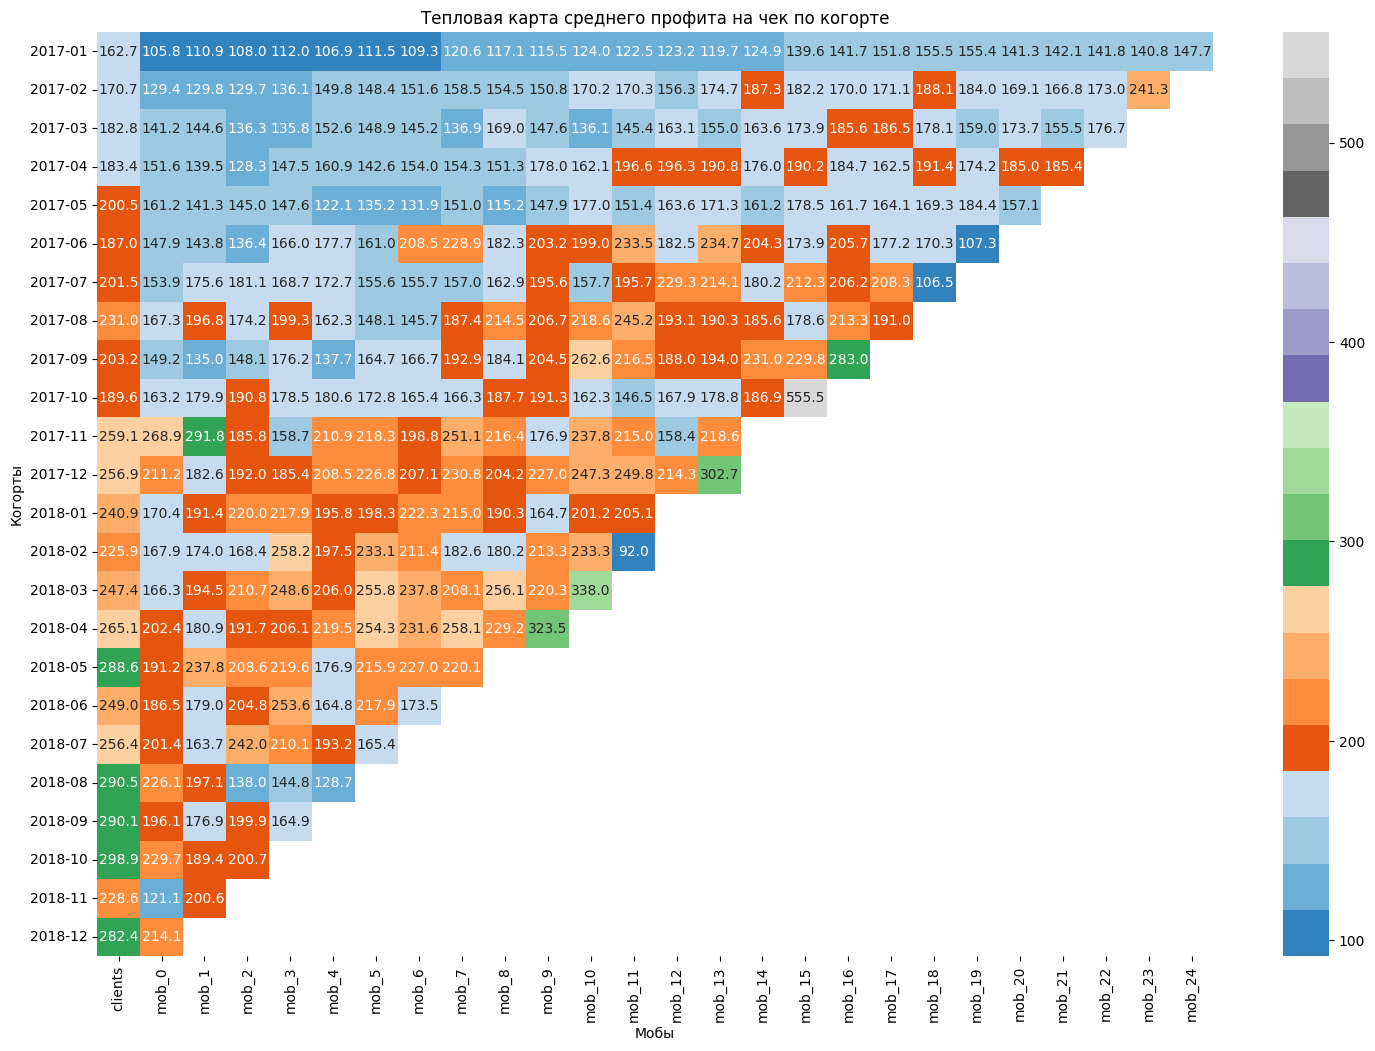

In [108]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  strftime('%Y-%m', cb.first_date) as cohort,
avg(case when rnk = 1 then profit end) as clients,
avg(case when rnk > 1 and mob=0 then profit end) as mob_0,
avg(case when mob=1 then profit end) as mob_1,
avg(case when mob=2 then profit end) as mob_2,
avg(case when mob=3 then profit end) as mob_3,
avg(case when mob=4 then profit end) as mob_4,
avg(case when mob=5 then profit end) as mob_5,
avg(case when mob=6 then profit end) as mob_6,
avg(case when mob=7 then profit end) as mob_7,
avg(case when mob=8 then profit end) as mob_8,
avg(case when mob=9 then profit end) as mob_9,
avg(case when mob=10 then profit end) as mob_10,
avg(case when mob=11 then profit end) as mob_11,
avg(case when mob=12 then profit end) as mob_12,
avg(case when mob=13 then profit end) as mob_13,
avg(case when mob=14 then profit end) as mob_14,
avg(case when mob=15 then profit end) as mob_15,
avg(case when mob=16 then profit end) as mob_16,
avg(case when mob=17 then profit end) as mob_17,
avg(case  when mob=18 then profit end) as mob_18,
avg(case when mob=19 then profit end) as mob_19,
avg(case when mob=20 then profit end) as mob_20,
avg(case when mob=21 then profit end) as mob_21,
avg(case when mob=22 then profit end) as mob_22,
avg(case when mob=23 then profit end) as mob_23,
avg(case when mob=24 then profit end) as mob_24
from clear_base cb
group by strftime('%Y-%m', cb.first_date)
 '''
data = pd.read_sql(query, conn)
data.set_index('cohort', inplace=True)

# Построение тепловой карты
plt.figure(figsize=(18, 12))
sns.heatmap(data, annot=True, fmt='.1f', cmap='tab20c')
plt.title('Тепловая карта среднего профита на чек по когорте')
plt.ylabel('Когорты')
plt.xlabel('Мобы')
plt.show()

Средний профит коррелирует со средним чеком. Это ожидаемо.  
Показатели по другим когортам имеют значительные колебания. Вероятно, это связано с минимальным количеством клиентов в мобе, любая аномалия, по которым имеет значительное влияние на среднее значение. 

#### Общая прибыль за всё время

Рассчитаем общую прибыль по когортам накопительным профитом.

In [167]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  sum(profit)
from clear_base cb
 '''
data = pd.read_sql(query, conn)
data

,sum(profit)
0,15757133


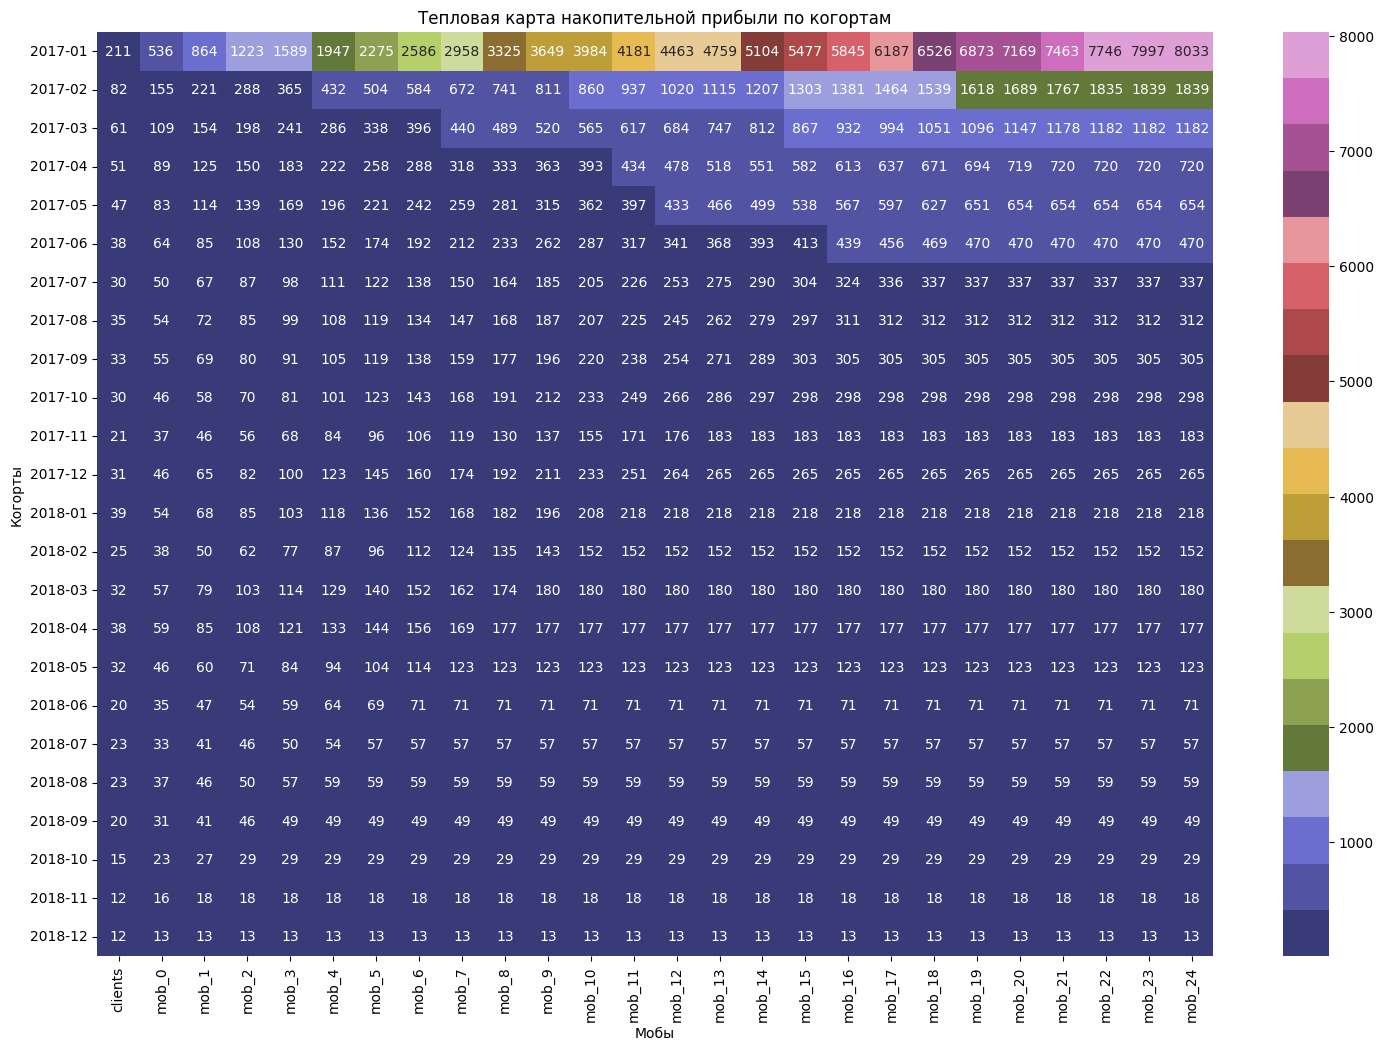

In [168]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  strftime('%Y-%m', cb.first_date)as cohort,
sum(case when rnk = 1 then profit end)/1000  as clients,
sum(case when mob=0 then profit end)/1000  as mob_0,
sum(case when mob<=1 then profit end)/1000  as mob_1,
sum(case when mob<=2 then profit end)/1000  as mob_2,
sum(case when mob<=3 then profit end)/1000  as mob_3,
sum(case when mob<=4 then profit end)/1000  as mob_4,
sum(case when mob<=5 then profit end)/1000  as mob_5,
sum(case when mob<=6 then profit end)/1000  as mob_6,
sum(case when mob<=7 then profit end)/1000  as mob_7,
sum(case when mob<=8 then profit end)/1000  as mob_8,
sum(case when mob<=9 then profit end)/1000  as mob_9,
sum(case when mob<=10 then profit end)/1000 as mob_10,
sum(case when mob<=11 then profit end)/1000  as mob_11,
sum(case when mob<=12 then profit end)/1000  as mob_12,
sum(case when mob<=13 then profit end)/1000  as mob_13,
sum(case when mob<=14 then profit end)/1000  as mob_14,
sum(case when mob<=15 then profit end)/1000  as mob_15,
sum(case when mob<=16 then profit end)/1000  as mob_16,
sum(case when mob<=17 then profit end)/1000  as mob_17,
sum(case  when mob<=18 then profit end)/1000  as mob_18,
sum(case when mob<=19 then profit end)/1000  as mob_19,
sum(case when mob<=20 then profit end)/1000  as mob_20,
sum(case when mob<=21 then profit end)/1000  as mob_21,
sum(case when mob<=22 then profit end)/1000  as mob_22,
sum(case when mob<=23 then profit end)/1000  as mob_23,
sum(case when mob<=24 then profit end)/1000  as mob_24
from clear_base cb
group by strftime('%Y-%m', cb.first_date)
 '''
data = pd.read_sql(query, conn)
data.set_index('cohort', inplace=True)

# Построение тепловой карты
plt.figure(figsize=(18, 12))
sns.heatmap(data, annot=True, fmt='.0f', cmap='tab20b')
plt.title('Тепловая карта накопительной прибыли по когортам')
plt.ylabel('Когорты')
plt.xlabel('Мобы')
plt.show()

Красочная визуализация, которая демонстрирует насколько существенно влияние первой когорты на общие показатели датасета.  
8 млн прибыли по всей когорте - это более 50% прибыли совокупного итога всех когорт. И это нельзя обьяснить только тем, что когорта самая старая.  
210 тысяч профита на стартовом мобе и 500 совокупно на нулевом это показатели, которые недоступно подавляющему большинству последущих когорт на периоде в 10 мобов.  
Так же стоит отметить существенное влияние когорт первого полугодия 2017 года. Несмотря на отрицательную динамику, даже показатели июня на первом чеке и нулевом мобе значительно превышают показатели последющих 18 когорт за те же периоды.

#### Средние траты на моб на 1 клиента

Метрика: средняя сумма трат на 1 клиента за моб (30 дней)


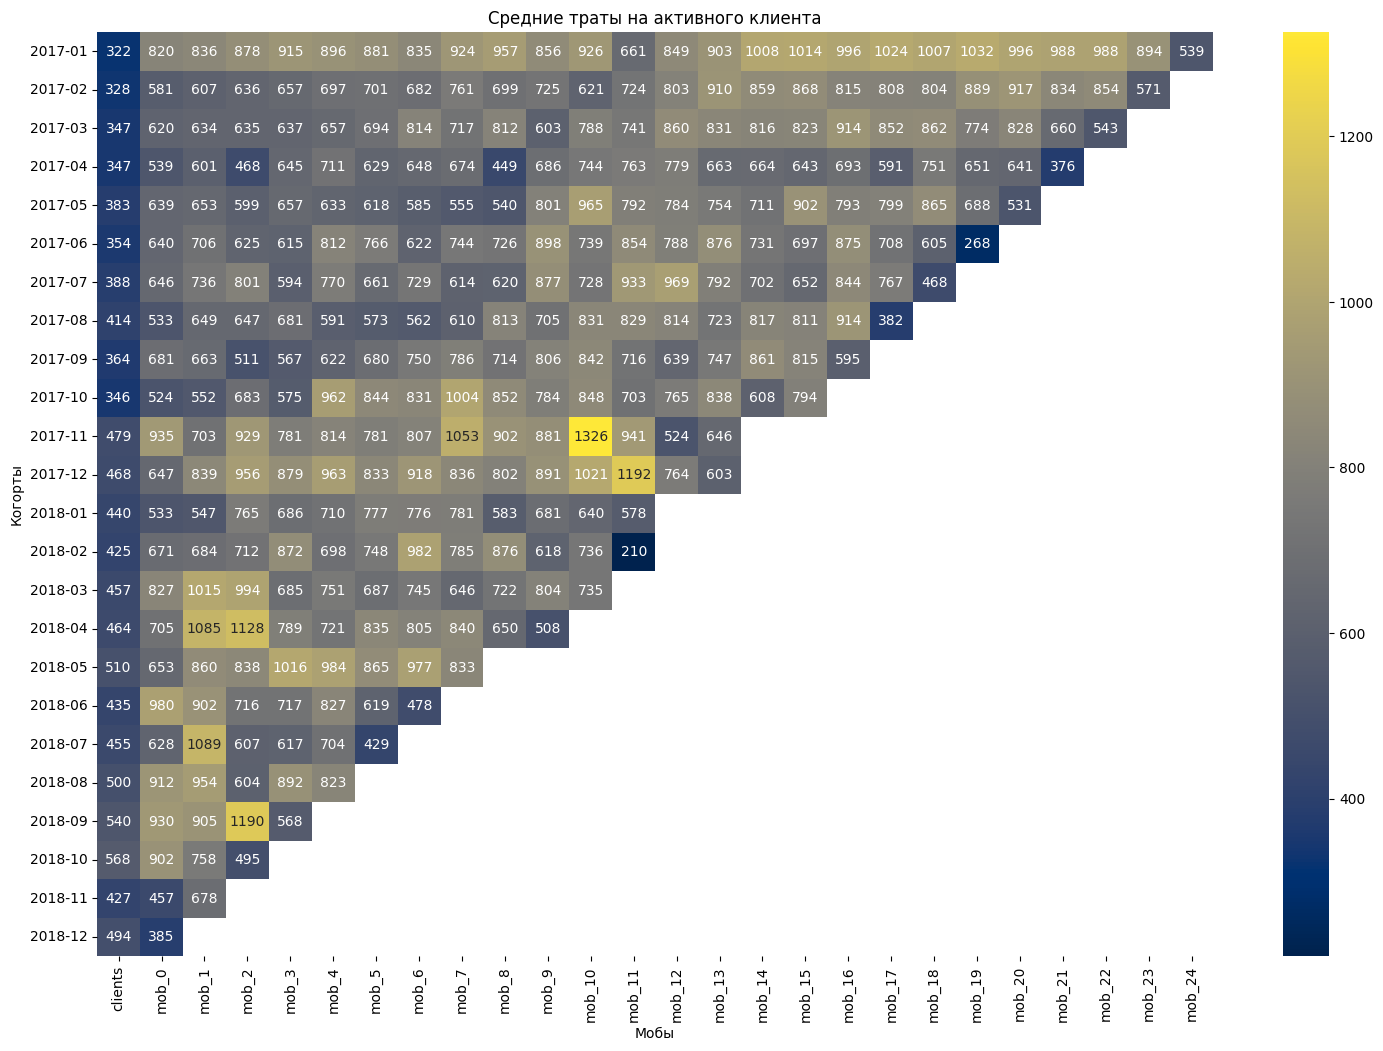

In [122]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  strftime('%Y-%m', cb.first_date)as cohort,
sum(case when rnk = 1 then sales end)*1.0/count(distinct case when rnk = 1 then user_id  end)*1.0 as clients,
sum(case when rnk > 1 and mob=0 then sales end)*1.0/count(distinct  case when rnk > 1 and mob=0 then user_id  end)*1.0  as mob_0,
sum(case when mob=1 then sales end)*1.0/count(distinct case when mob=1 then user_id end)*1.0   as mob_1,
sum(case when mob=2 then sales end)*1.0/count(distinct  case when mob=2 then user_id  end)*1.0 as mob_2,
sum(case when mob=3 then sales end)*1.0/count(distinct  case when mob=3 then user_id  end)*1.0  as mob_3,
sum(case when mob=4 then sales  end)*1.0/count(distinct  case when mob=4 then user_id  end)*1.0   as mob_4,
sum(case when mob=5 then sales end)*1.0/count(distinct  case when mob=5 then user_id  end)*1.0  as mob_5,
sum(case when mob=6 then sales end)*1.0/count(distinct  case when mob=6 then user_id  end)*1.0   as mob_6,
sum(case when mob=7 then sales end)*1.0/count(distinct  case when mob=7 then user_id  end)*1.0   as mob_7,
sum(case when mob=8 then sales end)*1.0/count(distinct  case when mob=8 then user_id  end)*1.0   as mob_8,
sum(case when mob=9 then sales end)*1.0/count(distinct  case when mob=9 then user_id  end)*1.0   as mob_9,
sum(case when mob=10 then sales end)*1.0/count(distinct  case when mob=10 then user_id  end)*1.0  as mob_10,
sum(case when mob=11 then sales end)*1.0/count(distinct  case when mob=11 then user_id  end)*1.0   as mob_11,
sum(case when mob=12 then sales end)*1.0/count(distinct  case when mob=12 then user_id  end)*1.0  as mob_12,
sum(case when mob=13 then sales end)*1.0/count(distinct  case when mob=13 then user_id  end)*1.0   as mob_13,
sum(case when mob=14 then sales end)*1.0/count(distinct  case when mob=14 then user_id  end)*1.0   as mob_14,
sum(case when mob=15 then sales end)*1.0/count(distinct  case when mob=15 then user_id  end)*1.0   as mob_15,
sum(case when mob=16 then sales end)*1.0/count(distinct  case when mob=16 then user_id  end)*1.0   as mob_16,
sum(case when mob=17 then sales end)*1.0/count(distinct  case when mob=17 then user_id  end)*1.0   as mob_17,
sum(case  when mob=18 then sales end)*1.0/count(distinct  case when mob=18 then user_id  end)*1.0   as mob_18,
sum(case when mob=19 then sales end)*1.0/count(distinct  case when mob=19 then user_id  end)*1.0  as mob_19,
sum(case when mob=20 then sales end)*1.0/count(distinct  case when mob=20 then user_id  end)*1.0   as mob_20,
sum(case when mob=21 then sales end)*1.0/count(distinct  case when mob=21 then user_id  end)*1.0   as mob_21,
sum(case when mob=22 then sales end)*1.0/count(distinct  case when mob=22 then user_id  end)*1.0  as mob_22,
sum(case when mob=23 then sales end)*1.0/count(distinct  case when mob=23 then user_id  end)*1.0  as mob_23,
sum(case when mob=24 then sales end)*1.0/count(distinct  case when mob=24 then user_id  end)*1.0  as mob_24
from clear_base cb
group by strftime('%Y-%m', cb.first_date)
 '''
data = pd.read_sql(query, conn)
data.set_index('cohort', inplace=True)

# Построение тепловой карты
plt.figure(figsize=(18, 12))
sns.heatmap(data, annot=True, fmt='.0f', cmap='cividis')
plt.title('Cредние траты на активного клиента')
plt.ylabel('Когорты')
plt.xlabel('Мобы')
plt.show()

Подтверждаем основную гипотезу.  
Несмотря на то, что средний чек первый когорты меньше, чем у остальных, за счет частоты она тратит больше в контексте 30 дневных периодов, чем остальные когорты.
При этом, есть отдельные мобы у отдельных когорт, которые могут сравниться по показателям, но мы сознательно не используем в сравнительном анализе выборке из малого количества наблюдений, которые очень подвержены влиянию выбросов.

#### Средний профит на 1 клиента в рамках моба

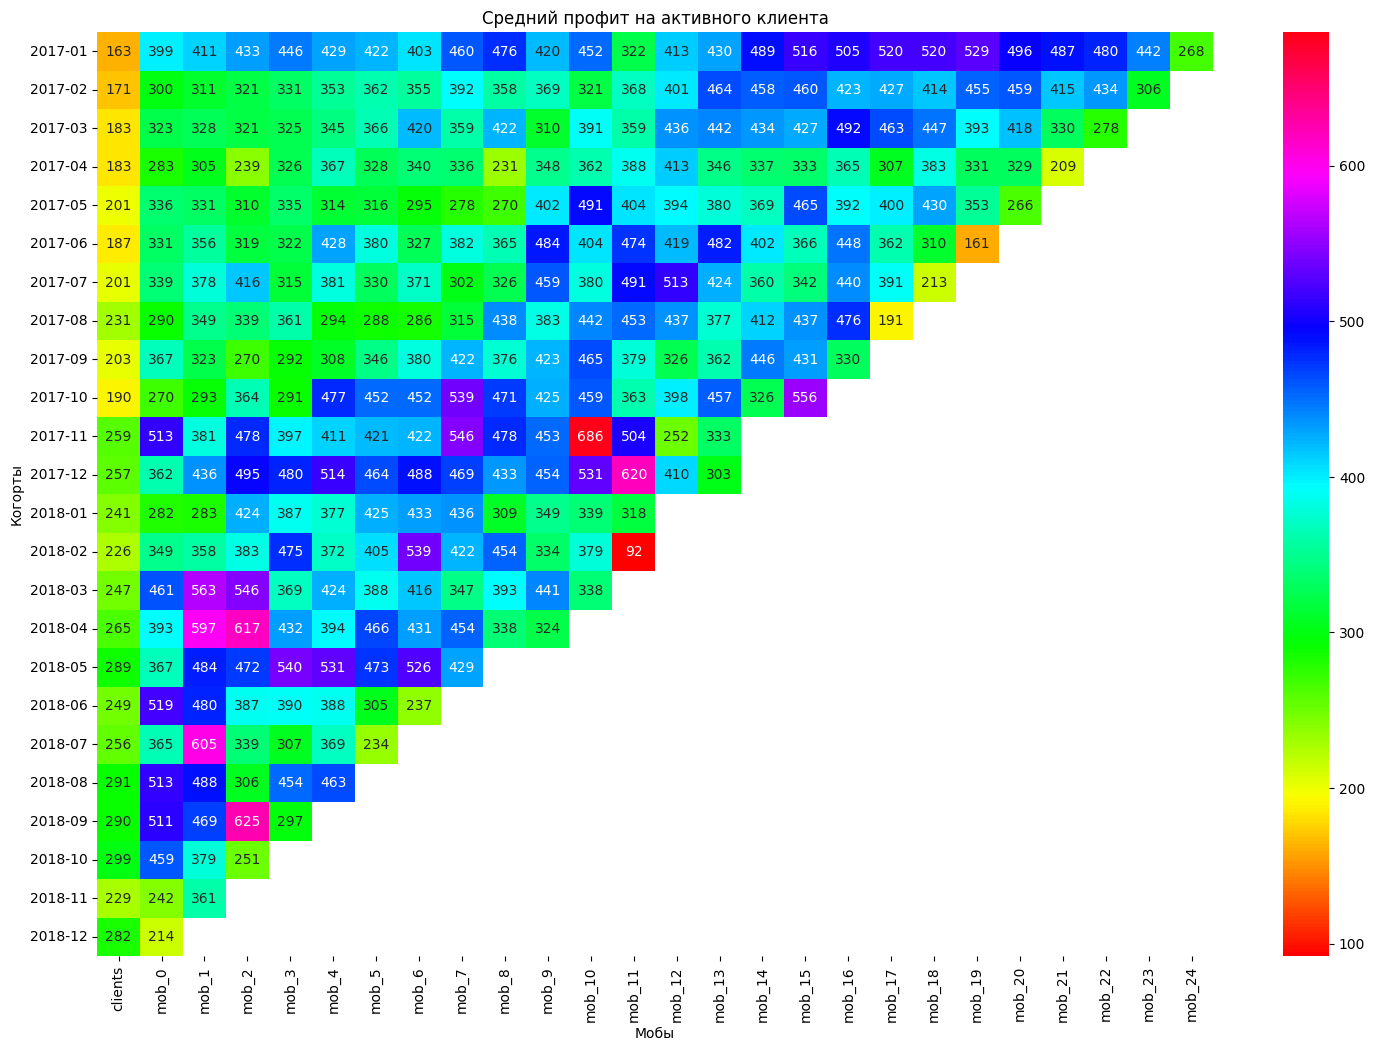

In [169]:
pd.set_option('display.max_columns', None)
query = '''
with base as (SELECT day_id,	check_time_dtm,	check_qnty_id,	single_show_name,	user_id,	sales,	sales_wo_vat,	cp_sum  FROM sales 
group by 1,2,3,4,5,6,7,8),
clear_base as (
SELECT 
b.*,
sales_wo_vat-cp_sum as profit,
MIN(day_id) OVER (PARTITION BY user_id) AS first_date,
ROW_NUMBER() OVER (PARTITION BY user_id  ORDER by day_id) as rnk,
cast((julianday(day_id) - julianday(MIN(day_id) OVER (PARTITION BY user_id)))/30 as integer) AS mob  
FROM base b)
select  strftime('%Y-%m', cb.first_date)as cohort,
sum(case when rnk = 1 then profit end)*1.0/count(distinct case when rnk = 1 then user_id  end)*1.0 as clients,
sum(case when rnk > 1 and mob=0 then profit end)*1.0/count(distinct  case when rnk > 1 and mob=0 then user_id  end)*1.0  as mob_0,
sum(case when mob=1 then profit end)*1.0/count(distinct case when mob=1 then user_id end)*1.0   as mob_1,
sum(case when mob=2 then profit end)*1.0/count(distinct  case when mob=2 then user_id  end)*1.0 as mob_2,
sum(case when mob=3 then profit end)*1.0/count(distinct  case when mob=3 then user_id  end)*1.0  as mob_3,
sum(case when mob=4 then profit end)*1.0/count(distinct  case when mob=4 then user_id  end)*1.0   as mob_4,
sum(case when mob=5 then profit end)*1.0/count(distinct  case when mob=5 then user_id  end)*1.0  as mob_5,
sum(case when mob=6 then profit end)*1.0/count(distinct  case when mob=6 then user_id  end)*1.0   as mob_6,
sum(case when mob=7 then profit end)*1.0/count(distinct  case when mob=7 then user_id  end)*1.0   as mob_7,
sum(case when mob=8 then profit end)*1.0/count(distinct  case when mob=8 then user_id  end)*1.0   as mob_8,
sum(case when mob=9 then profit end)*1.0/count(distinct  case when mob=9 then user_id  end)*1.0   as mob_9,
sum(case when mob=10 then profit end)*1.0/count(distinct  case when mob=10 then user_id  end)*1.0  as mob_10,
sum(case when mob=11 then profit end)*1.0/count(distinct  case when mob=11 then user_id  end)*1.0   as mob_11,
sum(case when mob=12 then profit end)*1.0/count(distinct  case when mob=12 then user_id  end)*1.0  as mob_12,
sum(case when mob=13 then profit end)*1.0/count(distinct  case when mob=13 then user_id  end)*1.0   as mob_13,
sum(case when mob=14 then profit end)*1.0/count(distinct  case when mob=14 then user_id  end)*1.0   as mob_14,
sum(case when mob=15 then profit end)*1.0/count(distinct  case when mob=15 then user_id  end)*1.0   as mob_15,
sum(case when mob=16 then profit end)*1.0/count(distinct  case when mob=16 then user_id  end)*1.0   as mob_16,
sum(case when mob=17 then profit end)*1.0/count(distinct  case when mob=17 then user_id  end)*1.0   as mob_17,
sum(case  when mob=18 then profit end)*1.0/count(distinct  case when mob=18 then user_id  end)*1.0   as mob_18,
sum(case when mob=19 then profit end)*1.0/count(distinct  case when mob=19 then user_id  end)*1.0  as mob_19,
sum(case when mob=20 then profit end)*1.0/count(distinct  case when mob=20 then user_id  end)*1.0   as mob_20,
sum(case when mob=21 then profit end)*1.0/count(distinct  case when mob=21 then user_id  end)*1.0   as mob_21,
sum(case when mob=22 then profit end)*1.0/count(distinct  case when mob=22 then user_id  end)*1.0  as mob_22,
sum(case when mob=23 then profit end)*1.0/count(distinct  case when mob=23 then user_id  end)*1.0  as mob_23,
sum(case when mob=24 then profit end)*1.0/count(distinct  case when mob=24 then user_id  end)*1.0  as mob_24
from clear_base cb
group by strftime('%Y-%m', cb.first_date)
 '''
data = pd.read_sql(query, conn)
data.set_index('cohort', inplace=True)

# Построение тепловой карты
plt.figure(figsize=(18, 12))
sns.heatmap(data, annot=True, fmt='.0f', cmap='hsv')
plt.title('Cредний профит на активного клиента')
plt.ylabel('Когорты')
plt.xlabel('Мобы')
plt.show()

По визуализации видно, что несмотря на низкий средний чек, высокая частотность дает первой когорте один из лучших показателей LTV клиента в рамках моба.
При этом отдельно стоит отметить когорту 12-2017, которая демонстрирует еще большие показатели, но на малом количестве клиентов это дает не существенный взнос в общую прибыль.  
**Отдельно можно отметить общую повышения метрики по мобам, которая может быть связана с влиянием инфляции.**

## Заключение по тестовому заданию для Бургер Кинга 🍔

## Введение 📊
В данном анализе был проведен когортный анализ клиентов Бургер Кинга на основе данных за 2017-2018 годы. Целью данного исследования было выявление паттернов поведения клиентов и определение факторов, способствующих прибыли.

## Данные 🔍
- **Период анализа:** 2017-2018 годы
- **Проблемы с данными:**
  - Пропуски: отсутствуют 🚫
  - Дубликаты: обнаружены и удалены (по одному клиенту) 🧹

## Основные выводы 📈
1. **Особенности:**
   - Когорты распределены не равномерны по датасету. Есть значительный перекос в сторону когорт первой половины 2017 года
   - Первые 3 когорты нагенерили прибыли больше, чем остальные 21
   - Несмотря на низкий средний чек первой когорты, высокая частотность позволила продемонстрировать лучшее VALUE среди всех когорт
   - Каналы продаж имеют разную динамику по активности клиентов. Спад активности в Приложении, стабильность показателей в Киоске
   - Срдений чек в Киоске в чаще всего выше, чем в Приложении
   - Первая когорта демонстрирует выдающиеся результаты по активной клиентой базе, 40%+ спустя 20 месяцев это значительно выше, чем большинство когорт на периоде 12 месяцев
   - В датасете почти 10% чеков, которые показывают орицательную себестоимость(убыток)

2. **Анализ поведения клиентов:**
   -  🎉Основная гипотеза это система бонусов, лояльности, промокоды, которые были более доступны клиентам первых нескольких когорт. Клиенты получил доступ к акционным предложения, это повысило их активность на долгосрочном периоде, возможно это какие-то акционные предложения по комбо обедам, которые не имеют высокого среднего чек, но имеют низкую себестоимость и за счет высокой частотности такие клиенты дают генерируют хорошую прибыль.


## Рекомендации 💡
- Необходимо консультация с бизнес-экспертом на предмет корректности логики чеков с отрицательной себестоимостью. Это может быть как техническая ошибка, так и сознательная политика клиентской лояльности. На основании этого необходимо сделать вывод о включении, либо исключении данных кейсов из анализа. В данном исследование подобные кейсы были использованы в анализе.

## Заключение 📝
В рамках экспресс исследования были выявлены полыне дубликаты, а также неравномерное по когортам. Низкий средний чек по первой когорте не оказал существенного влияния на прибыльность когорты, а вот частотность, наоборот, вывела когорту в жирны плюс.   
Для более предметных выводов требуется более детализированное исследование, которое должно в себя включать признаки наличия у клиентов программы лояльности, применения промокодов, покупки акционных товаров. Это позволит произвести более детальную сегментацию, чтобы выявить более профилированные паттерны клиентского поведения.
Также время покупки, как и канал продаж может иметь дополнительные инсайты при более детализированном исследовании.  
Рекомендуется привлечь к обсуждению результатов исследования бизнес-экспретов, для определения пробелов логики и получения болеее предметных выводов.

---